In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd
from sympy import Symbol
from sympy.solvers import solve
import sympy as sp

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [110]:
# Closed Loop dataset
exp_ids=['2018_05_24_14_20_18_Open loop with atoms',
         '2018_05_24_14_31_57_Open loop with atoms',
         '2018_05_24_14_50_50_Open loop with atoms',
         '2018_05_24_15_11_23_Open loop with atoms',
         '2018_05_24_15_23_23_Open loop with atoms',
         '2018_05_24_15_45_20_Open loop with atoms',
         '2018_05_24_16_02_54_Open loop with atoms',
         '2018_05_24_16_14_11_Open loop with atoms',
         '2018_05_24_16_25_38_Open loop with atoms',
         '2018_05_24_16_37_11_Open loop with atoms',
         '2018_05_24_16_48_35_Open loop with atoms',
         '2018_05_24_16_59_59_Open loop with atoms',
         '2018_05_24_17_12_08_Open loop with atoms',
         '2018_05_24_17_24_41_Open loop with atoms',
         '2018_05_24_17_36_57_Open loop with atoms',
         '2018_05_24_17_49_06_Open loop with atoms',
         '2018_05_24_18_01_07_Open loop with atoms',
         '2018_05_24_18_14_58_Open loop with atoms',
         '2018_05_24_18_35_07_Open loop with atoms',
         '2018_05_24_18_49_00_Open loop with atoms',
         '2018_05_24_19_02_45_Open loop with atoms',
         '2018_05_24_20_07_39_Open loop with atoms',
         '2018_05_24_20_25_00_Open loop with atoms',
         '2018_05_24_22_41_26_Open loop with atoms',
         '2018_05_24_23_17_53_Open loop with atoms',
         '2018_05_25_03_19_13_Open loop, with atoms, side off',
         '2018_05_25_03_47_46_Open loop, with atoms, side off',
         '2018_05_25_04_08_37_Open loop, with atoms, side off',
         '2018_05_25_04_30_15_Open loop, with atoms, side off'
         
        ]


In [111]:
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_14_20_18_Open loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_14_31_57_Open loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_14_50_50_Open loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_15_11_23_Open loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_15_23_23_Open loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_15_45_20_Open loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_16_02_54_Open loop with atoms/

# Experiment-wise analysis

2018_05_24_14_20_18_Open loop with atoms
0


<IPython.core.display.Javascript object>


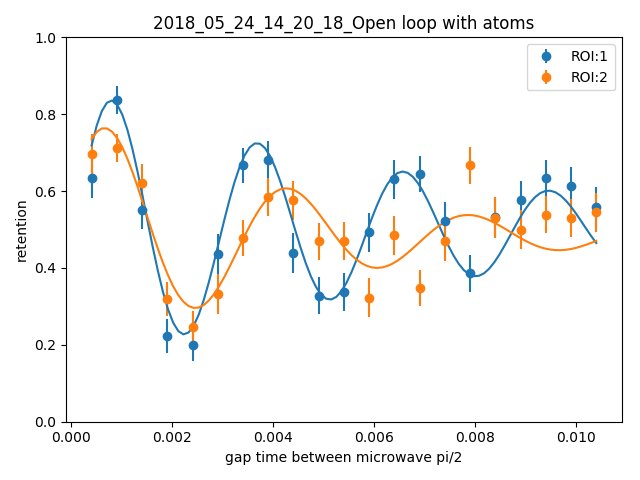

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00718861828163  with 1 std of   0.00183626631096
amplitude 1  is  0.374355002015  with 1 std of   0.0532081328736
frequency 1  is  346.163168803  with 1 std of   5.50684768263
phase 1  is  -0.207091205319  with 1 std of   0.143096738193
offset 1  is  0.500959952157  with 1 std of   0.0129253515247
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00441458293477  with 1 std of   0.00149902157209
amplitude 2  is  0.328890581869  with 1 std of   0.0730268668244
frequency 2  is  277.622644598  with 1 std of   13.5274998366
phase 2  is  0.302175737112  with 1 std of   0.27756402746
offset 2  is  0.482829809873  with 1 std of   0.0164603129552
2018_05_24_14_31_57_Open loop with atoms
1


<IPython.core.display.Javascript object>


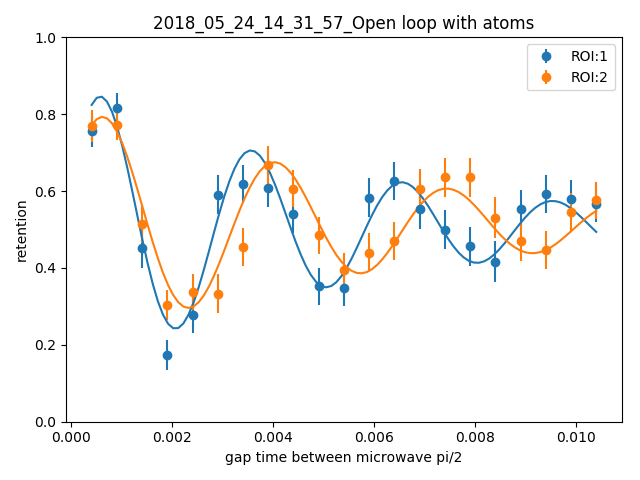

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00564906614812  with 1 std of   0.00121034277596
amplitude 1  is  0.379493268243  with 1 std of   0.0486856136293
frequency 1  is  334.825347659  with 1 std of   6.55345053773
phase 1  is  0.288575502526  with 1 std of   0.155606052116
offset 1  is  0.504410629222  with 1 std of   0.0120068856766
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00629496089063  with 1 std of   0.00158390251958
amplitude 2  is  0.312024893904  with 1 std of   0.0447034616371
frequency 2  is  293.367865344  with 1 std of   6.94799362524
phase 2  is  0.354999895718  with 1 std of   0.174972924366
offset 2  is  0.511157195864  with 1 std of   0.0115922774907
2018_05_24_14_50_50_Open loop with atoms
2


<IPython.core.display.Javascript object>


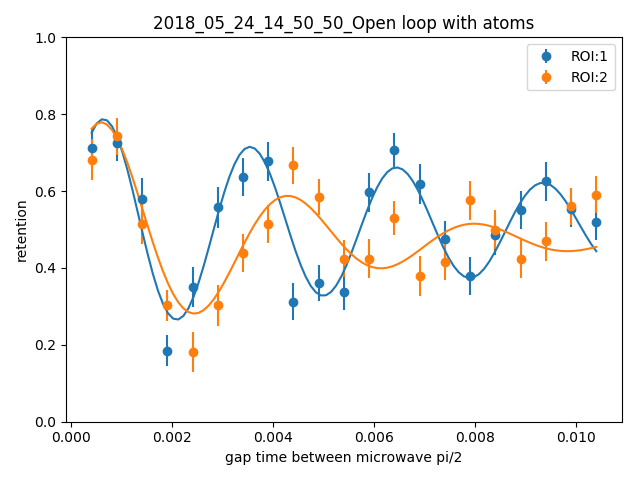

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00975166437587  with 1 std of   0.00358104572912
amplitude 1  is  0.29949832332  with 1 std of   0.0497551150958
frequency 1  is  344.328210062  with 1 std of   6.26986341748
phase 1  is  0.153853108961  with 1 std of   0.18642021931
offset 1  is  0.507011755148  with 1 std of   0.013977812893
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00380805541931  with 1 std of   0.0013074335858
amplitude 2  is  0.363947544446  with 1 std of   0.0835267476312
frequency 2  is  270.667810509  with 1 std of   16.6177625433
phase 2  is  0.416058447775  with 1 std of   0.310348316765
offset 2  is  0.4709084479  with 1 std of   0.0181644524358
2018_05_24_15_11_23_Open loop with atoms
3


<IPython.core.display.Javascript object>


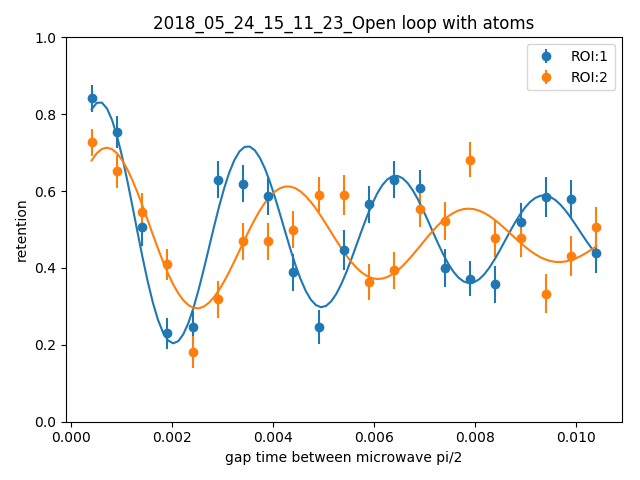

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00724624122807  with 1 std of   0.00161139868417
amplitude 1  is  0.374071606472  with 1 std of   0.0444375755321
frequency 1  is  340.814638227  with 1 std of   5.25927375289
phase 1  is  0.316416830999  with 1 std of   0.140856132546
offset 1  is  0.486239861126  with 1 std of   0.0118366971884
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00651059006705  with 1 std of   0.00311596064013
amplitude 2  is  0.265641556909  with 1 std of   0.0722459540696
frequency 2  is  278.964836219  with 1 std of   12.5511249354
phase 2  is  0.257861680635  with 1 std of   0.319370654995
offset 2  is  0.475308200636  with 1 std of   0.0186111613645
2018_05_24_15_23_23_Open loop with atoms
4


<IPython.core.display.Javascript object>


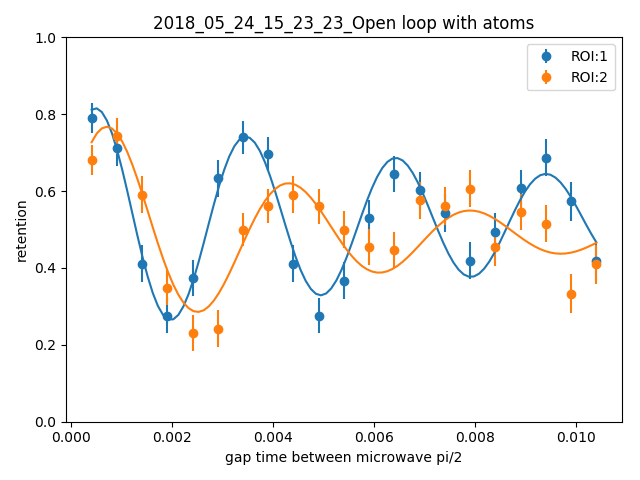

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.0103261421718  with 1 std of   0.00264170348506
amplitude 1  is  0.309484976755  with 1 std of   0.0339979874835
frequency 1  is  336.190265311  with 1 std of   4.18986092157
phase 1  is  0.513839428395  with 1 std of   0.128401155074
offset 1  is  0.520431662274  with 1 std of   0.00992226125729
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00494620627025  with 1 std of   0.00155738474541
amplitude 2  is  -0.329697394608  with 1 std of   0.0662384746466
frequency 2  is  277.864264382  with 1 std of   10.9710362233
phase 2  is  3.37489506817  with 1 std of   0.240248474105
offset 2  is  0.483163280044  with 1 std of   0.0153787229134
2018_05_24_15_45_20_Open loop with atoms
5


<IPython.core.display.Javascript object>


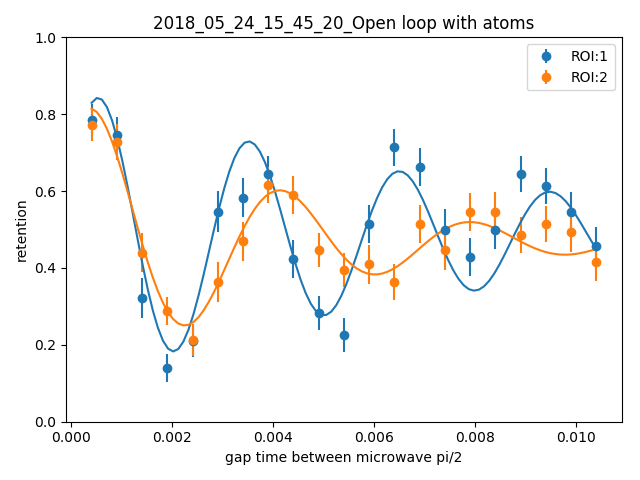

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00792037407741  with 1 std of   0.002564837812
amplitude 1  is  0.38643883811  with 1 std of   0.0633397070898
frequency 1  is  335.258489369  with 1 std of   6.96329835848
phase 1  is  0.400417172385  with 1 std of   0.19473154675
offset 1  is  0.48179134119  with 1 std of   0.0173746609174
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00397741522457  with 1 std of   0.000727908698131
amplitude 2  is  0.385447897879  with 1 std of   0.0463425125187
frequency 2  is  265.503605221  with 1 std of   8.8328991668
phase 2  is  0.81767852066  with 1 std of   0.170090581252
offset 2  is  0.467130154688  with 1 std of   0.0106104010991
2018_05_24_16_02_54_Open loop with atoms
6


<IPython.core.display.Javascript object>


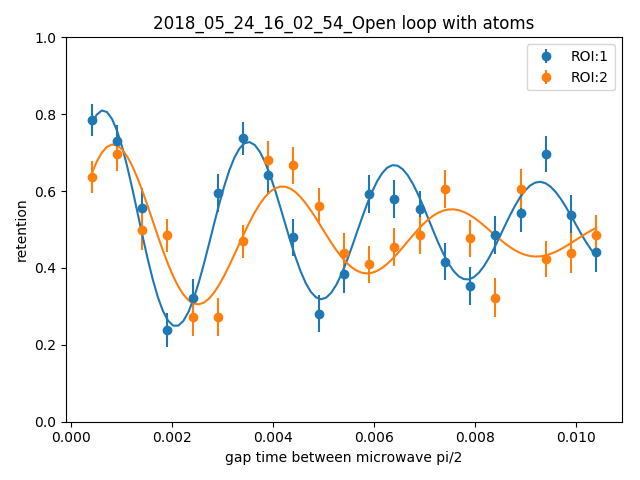

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00910388786281  with 1 std of   0.00200807568808
amplitude 1  is  0.324967340728  with 1 std of   0.0340206533994
frequency 1  is  346.753388326  with 1 std of   4.09753294905
phase 1  is  0.157957651703  with 1 std of   0.118504153791
offset 1  is  0.507046458655  with 1 std of   0.00943240735462
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00550713406296  with 1 std of   0.00252555498472
amplitude 2  is  -0.279465338075  with 1 std of   0.0806873016348
frequency 2  is  298.104033761  with 1 std of   13.0125049561
phase 2  is  3.07066652373  with 1 std of   0.297524968266
offset 2  is  0.481888634648  with 1 std of   0.017990644908
2018_05_24_16_14_11_Open loop with atoms
7


<IPython.core.display.Javascript object>


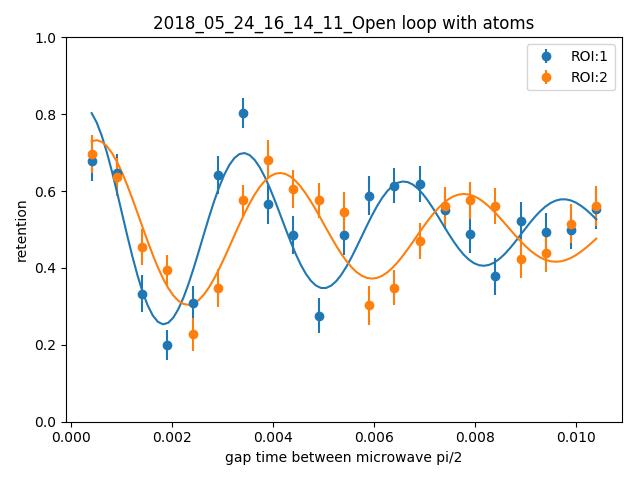

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00670495854964  with 1 std of   0.00227825013613
amplitude 1  is  0.32799876831  with 1 std of   0.0632138732816
frequency 1  is  315.566741837  with 1 std of   8.72459730045
phase 1  is  1.01456491539  with 1 std of   0.222477752593
offset 1  is  0.502436049718  with 1 std of   0.0160866107485
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00821171979866  with 1 std of   0.00326455590253
amplitude 2  is  0.253117102331  with 1 std of   0.0496656130459
frequency 2  is  274.417441303  with 1 std of   8.52433643155
phase 2  is  0.657827470285  with 1 std of   0.241498749846
offset 2  is  0.494592573799  with 1 std of   0.0141803366948
2018_05_24_16_25_38_Open loop with atoms
8


<IPython.core.display.Javascript object>


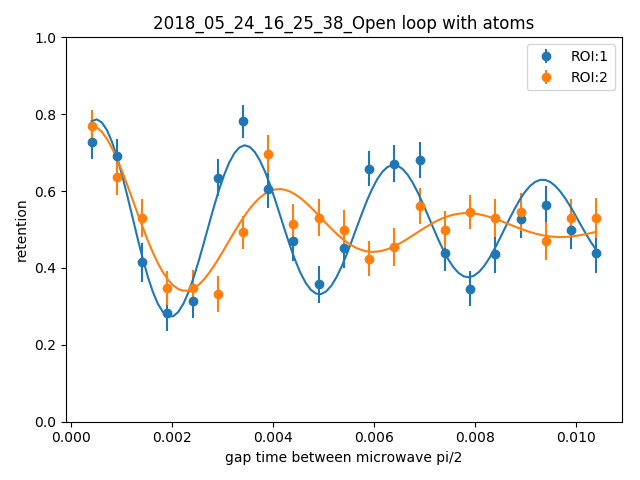

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.0104598444816  with 1 std of   0.00322945594398
amplitude 1  is  0.288407133997  with 1 std of   0.0380396036248
frequency 1  is  339.064101214  with 1 std of   5.03409575323
phase 1  is  0.485652448581  with 1 std of   0.154212575706
offset 1  is  0.511731726839  with 1 std of   0.0111350644287
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00384992258067  with 1 std of   0.000996511529442
amplitude 2  is  0.297796915661  with 1 std of   0.05058457597
frequency 2  is  268.870676345  with 1 std of   12.8836648331
phase 2  is  0.749022043026  with 1 std of   0.243455229367
offset 2  is  0.504206073438  with 1 std of   0.011491449263
2018_05_24_16_37_11_Open loop with atoms
9


<IPython.core.display.Javascript object>


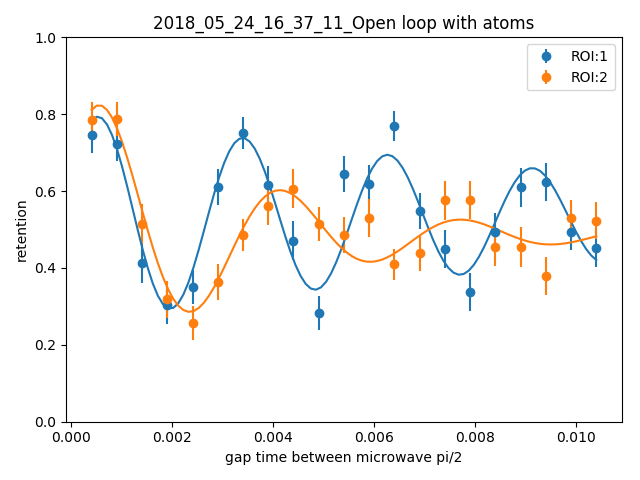

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.012212709354  with 1 std of   0.0050336585259
amplitude 1  is  0.27624388637  with 1 std of   0.0444697519875
frequency 1  is  348.513953393  with 1 std of   6.00528039291
phase 1  is  0.387889871692  with 1 std of   0.187910421365
offset 1  is  0.52926126295  with 1 std of   0.0134407390989
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00337852813407  with 1 std of   0.00072476590062
amplitude 2  is  0.40397761598  with 1 std of   0.0585075968719
frequency 2  is  279.479575448  with 1 std of   11.7312948098
phase 2  is  0.437367808813  with 1 std of   0.202158132742
offset 2  is  0.485092342426  with 1 std of   0.0121025410689
2018_05_24_16_48_35_Open loop with atoms
10


<IPython.core.display.Javascript object>


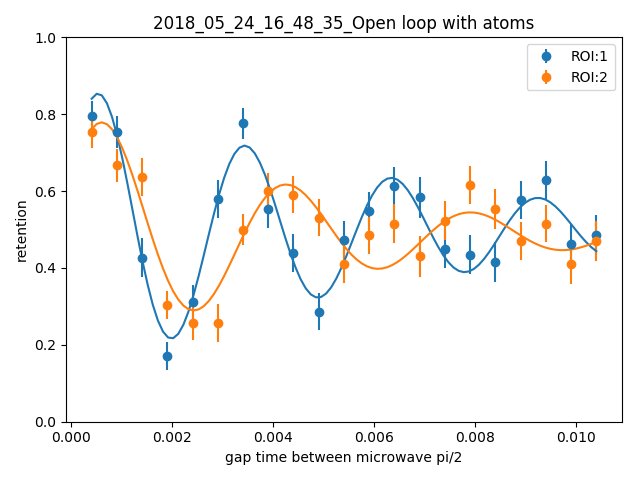

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00608794300403  with 1 std of   0.00104870821556
amplitude 1  is  0.389864272413  with 1 std of   0.0390741584551
frequency 1  is  344.203654592  with 1 std of   4.98820794206
phase 1  is  0.35612751119  with 1 std of   0.122459570954
offset 1  is  0.497197051946  with 1 std of   0.00996313037902
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00455242788005  with 1 std of   0.00124179074996
amplitude 2  is  0.336950020116  with 1 std of   0.0589755148102
frequency 2  is  273.771492959  with 1 std of   10.8678770042
phase 2  is  0.416095218188  with 1 std of   0.228222017409
offset 2  is  0.485723511125  with 1 std of   0.0138386635731
2018_05_24_16_59_59_Open loop with atoms
11


<IPython.core.display.Javascript object>


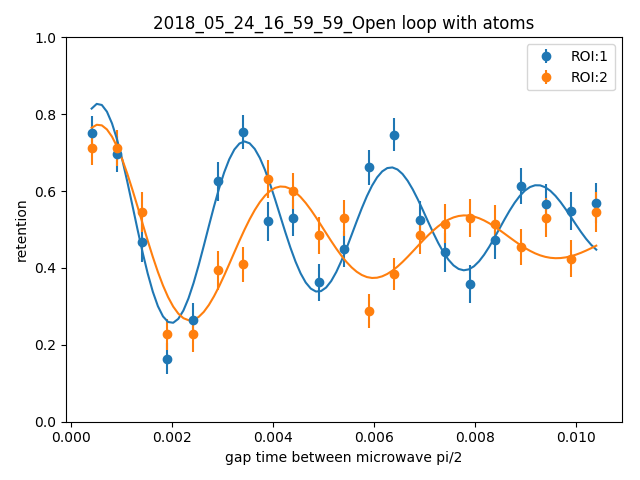

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00766460844371  with 1 std of   0.0025277834064
amplitude 1  is  0.335407247567  with 1 std of   0.0576413205692
frequency 1  is  344.807931737  with 1 std of   7.52808032516
phase 1  is  0.357832637255  with 1 std of   0.205050549569
offset 1  is  0.515228823131  with 1 std of   0.0156804834983
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00478056958814  with 1 std of   0.00133560336897
amplitude 2  is  0.340665772857  with 1 std of   0.05957383429
frequency 2  is  275.339183669  with 1 std of   10.6559777374
phase 2  is  0.525194336727  with 1 std of   0.231827474073
offset 2  is  0.470633951137  with 1 std of   0.0144825144715
2018_05_24_17_12_08_Open loop with atoms
12


<IPython.core.display.Javascript object>


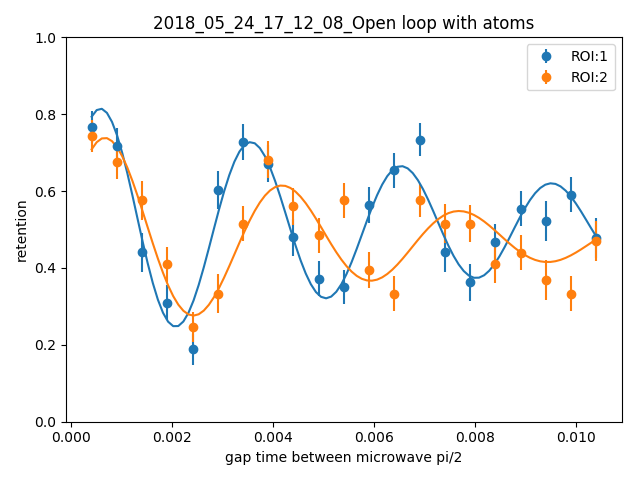

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.0089317525227  with 1 std of   0.00260624314802
amplitude 1  is  0.32812999903  with 1 std of   0.0452716325053
frequency 1  is  335.743590473  with 1 std of   5.47674622213
phase 1  is  0.304726397116  with 1 std of   0.159991900864
offset 1  is  0.507348443102  with 1 std of   0.012674525083
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00562577044966  with 1 std of   0.00202963916443
amplitude 2  is  0.301771791393  with 1 std of   0.0652408971538
frequency 2  is  284.974162482  with 1 std of   10.8904594052
phase 2  is  0.287708590264  with 1 std of   0.259371384115
offset 2  is  0.471513892898  with 1 std of   0.0160736525649
2018_05_24_17_24_41_Open loop with atoms
13


<IPython.core.display.Javascript object>


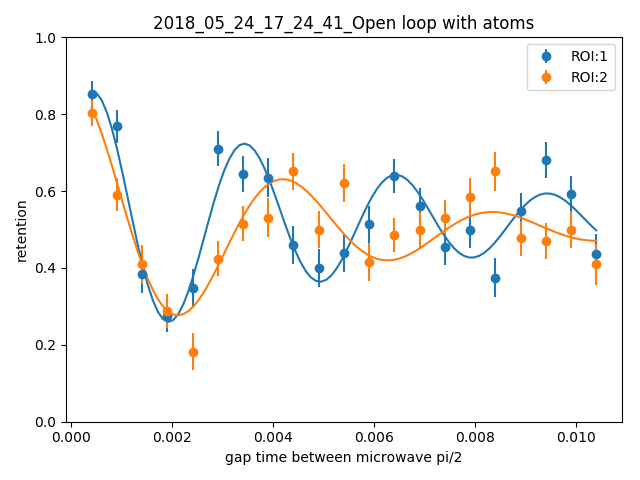

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00588129353397  with 1 std of   0.00140219969419
amplitude 1  is  0.363907773049  with 1 std of   0.050679844362
frequency 1  is  333.241381084  with 1 std of   7.11851859237
phase 1  is  0.599867529868  with 1 std of   0.173493363477
offset 1  is  0.521014617674  with 1 std of   0.0129051118581
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00402138883122  with 1 std of   0.00115831210183
amplitude 2  is  0.379840121746  with 1 std of   0.0785019723997
frequency 2  is  240.675808226  with 1 std of   12.4428680641
phase 2  is  1.36036430792  with 1 std of   0.232857439748
offset 2  is  0.498623566887  with 1 std of   0.0155634382011
2018_05_24_17_36_57_Open loop with atoms
14


<IPython.core.display.Javascript object>


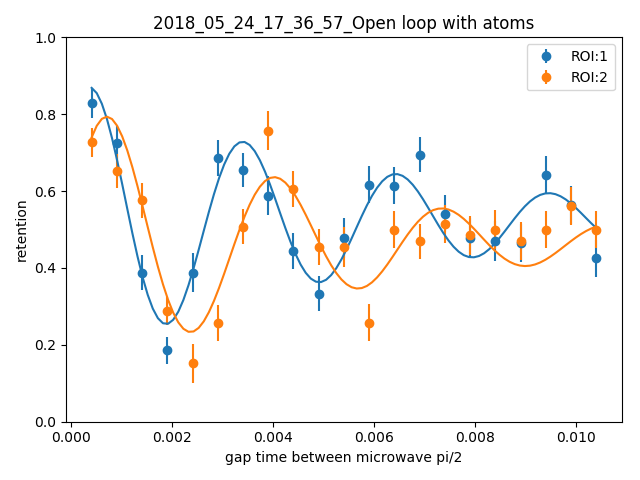

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00581569137643  with 1 std of   0.00138614960219
amplitude 1  is  0.3712326558  with 1 std of   0.0521508938484
frequency 1  is  329.658817889  with 1 std of   7.15431111454
phase 1  is  0.745373469266  with 1 std of   0.173039172477
offset 1  is  0.521941950044  with 1 std of   0.0131241170669
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00503277115616  with 1 std of   0.00158581757409
amplitude 2  is  0.376725457151  with 1 std of   0.0759417245513
frequency 2  is  301.48018658  with 1 std of   10.7222257243
phase 2  is  0.139079881045  with 1 std of   0.234923928013
offset 2  is  0.467717869591  with 1 std of   0.0173769181995
2018_05_24_17_49_06_Open loop with atoms
15


<IPython.core.display.Javascript object>


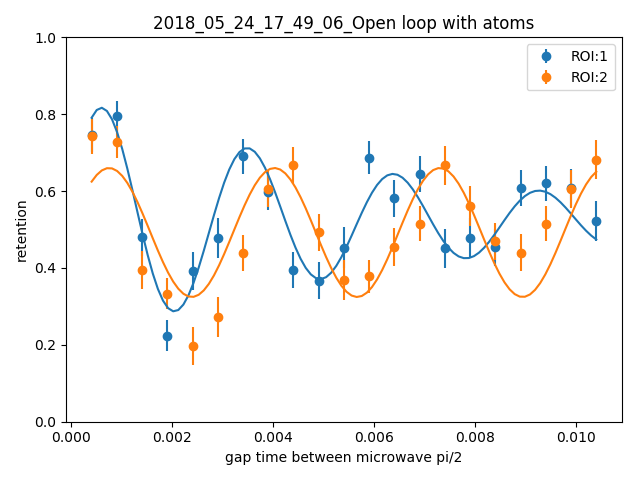

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00656370533461  with 1 std of   0.0018852200249
amplitude 1  is  0.32250528275  with 1 std of   0.0525054319747
frequency 1  is  345.986518558  with 1 std of   7.54253152905
phase 1  is  0.213350996837  with 1 std of   0.191317655033
offset 1  is  0.522879409944  with 1 std of   0.013446941297
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  -125030.614612  with 1 std of   460305961272.0
amplitude 2  is  -0.167798246981  with 1 std of   0.0437906876004
frequency 2  is  305.086704299  with 1 std of   10.1662598147
phase 2  is  -2.99972471457  with 1 std of   0.388310301915
offset 2  is  0.492284607097  with 1 std of   0.0215264776691
2018_05_24_18_01_07_Open loop with atoms
16


<IPython.core.display.Javascript object>


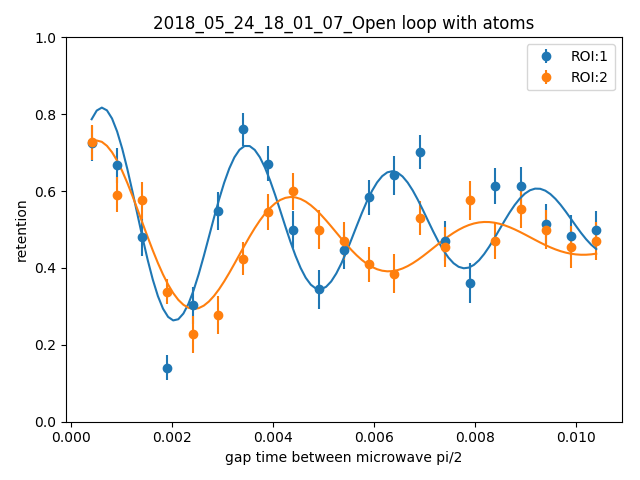

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00732616654971  with 1 std of   0.00256368398645
amplitude 1  is  0.330852179473  with 1 std of   0.0623420543085
frequency 1  is  347.784570444  with 1 std of   8.22689805363
phase 1  is  0.189621617042  with 1 std of   0.218542779806
offset 1  is  0.513091910493  with 1 std of   0.0164427529573
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00471681932658  with 1 std of   0.00127722511689
amplitude 2  is  -0.295226637237  with 1 std of   0.0505781102854
frequency 2  is  259.378925884  with 1 std of   10.9736352877
phase 2  is  3.76499276799  with 1 std of   0.235491225103
offset 2  is  0.46840411241  with 1 std of   0.012383383672
2018_05_24_18_14_58_Open loop with atoms
17


<IPython.core.display.Javascript object>


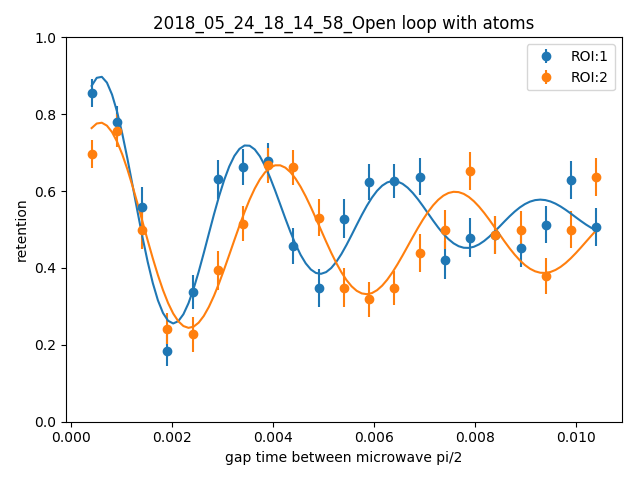

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00445918173406  with 1 std of   0.00100083872021
amplitude 1  is  0.426114973949  with 1 std of   0.0622292077817
frequency 1  is  343.861023159  with 1 std of   8.86347705231
phase 1  is  0.245107825342  with 1 std of   0.181185526387
offset 1  is  0.525039687033  with 1 std of   0.0139950381748
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00758330135745  with 1 std of   0.00245063507811
amplitude 2  is  0.322062734212  with 1 std of   0.0533853649474
frequency 2  is  284.554478039  with 1 std of   7.28609720061
phase 2  is  0.473693637838  with 1 std of   0.201418802691
offset 2  is  0.480410087094  with 1 std of   0.0147884463613
2018_05_24_18_35_07_Open loop with atoms
18


<IPython.core.display.Javascript object>


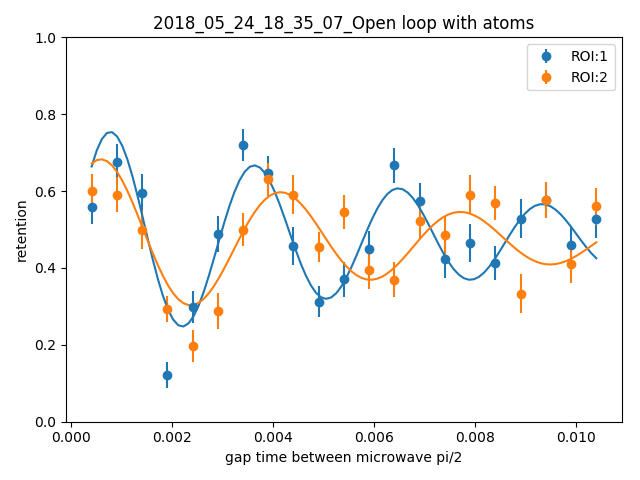

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00754911934464  with 1 std of   0.00297246256371
amplitude 1  is  0.307526599869  with 1 std of   0.0656807367466
frequency 1  is  350.533782178  with 1 std of   8.24598596485
phase 1  is  -0.184825035512  with 1 std of   0.218075457252
offset 1  is  0.476967596641  with 1 std of   0.0163213946456
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00697307780104  with 1 std of   0.00396582822968
amplitude 2  is  -0.233446926073  with 1 std of   0.0714017428032
frequency 2  is  280.796014277  with 1 std of   14.0963557613
phase 2  is  3.60456758289  with 1 std of   0.375132939576
offset 2  is  0.46875233603  with 1 std of   0.0193455226511
2018_05_24_18_49_00_Open loop with atoms
19


<IPython.core.display.Javascript object>


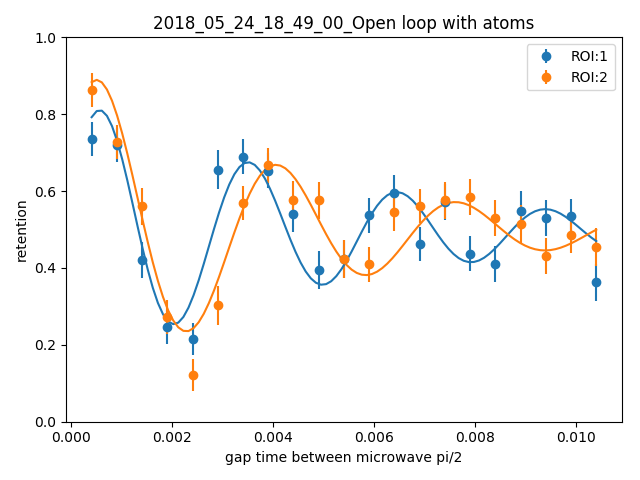

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00527605397601  with 1 std of   0.00156122935584
amplitude 1  is  0.353865584928  with 1 std of   0.0643339420442
frequency 1  is  339.769877049  with 1 std of   9.761185814
phase 1  is  0.290434522036  with 1 std of   0.222534730584
offset 1  is  0.493586291361  with 1 std of   0.0155063370033
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00431175190071  with 1 std of   0.000860012635213
amplitude 2  is  0.445733861814  with 1 std of   0.0568045905015
frequency 2  is  281.392918973  with 1 std of   8.46059865224
phase 2  is  0.558939993725  with 1 std of   0.17309450126
offset 2  is  0.495742467727  with 1 std of   0.0133354900895
2018_05_24_19_02_45_Open loop with atoms
20


<IPython.core.display.Javascript object>


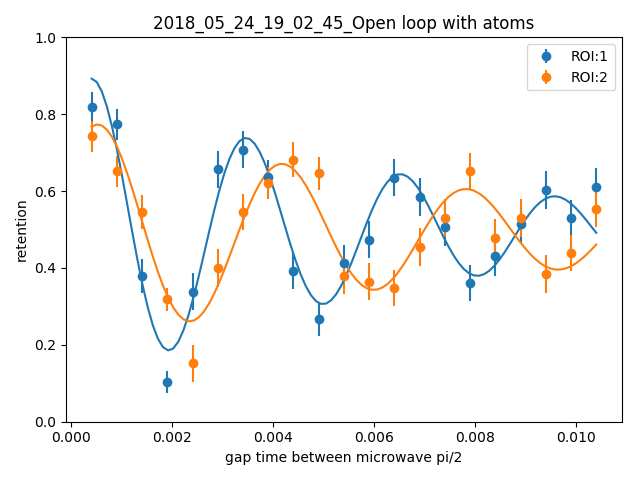

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00622443628733  with 1 std of   0.00124262902482
amplitude 1  is  0.424301056654  with 1 std of   0.0483948645934
frequency 1  is  327.06309617  with 1 std of   5.62199388972
phase 1  is  0.671940167556  with 1 std of   0.14101827883
offset 1  is  0.495707182052  with 1 std of   0.0125213593601
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00817528536184  with 1 std of   0.00260917268207
amplitude 2  is  0.304170151772  with 1 std of   0.048132699846
frequency 2  is  274.131786118  with 1 std of   6.90510616599
phase 2  is  0.603200867271  with 1 std of   0.19496017088
offset 2  is  0.488809074559  with 1 std of   0.0137305628181
2018_05_24_20_07_39_Open loop with atoms
21


<IPython.core.display.Javascript object>


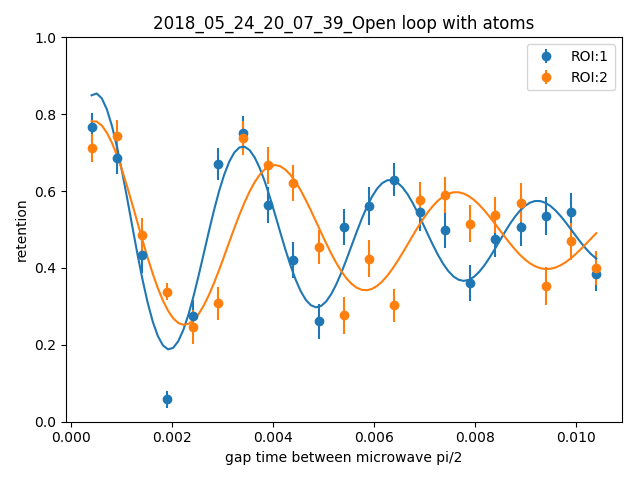

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00627497094053  with 1 std of   0.00152896698919
amplitude 1  is  0.402289578804  with 1 std of   0.0561112981895
frequency 1  is  342.564287194  with 1 std of   6.88929947629
phase 1  is  0.469230952631  with 1 std of   0.172063684821
offset 1  is  0.482611612058  with 1 std of   0.0145552299644
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.0073722834226  with 1 std of   0.00314640981633
amplitude 2  is  0.316546455729  with 1 std of   0.0703878463045
frequency 2  is  278.38405003  with 1 std of   10.0812990531
phase 2  is  0.727891571337  with 1 std of   0.275089942209
offset 2  is  0.48513210504  with 1 std of   0.0195237349378
2018_05_24_20_25_00_Open loop with atoms
22


<IPython.core.display.Javascript object>


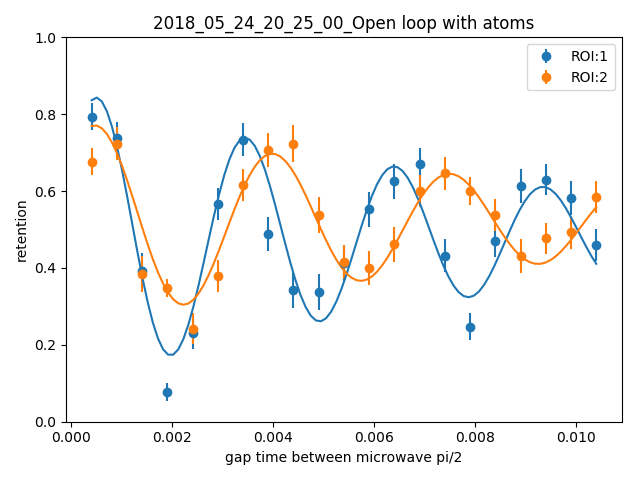

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00870046265135  with 1 std of   0.00255037068402
amplitude 1  is  0.385370313016  with 1 std of   0.0542702099847
frequency 1  is  338.978328224  with 1 std of   5.78691881317
phase 1  is  0.47111268253  with 1 std of   0.167018266175
offset 1  is  0.479617239017  with 1 std of   0.0152790100582
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.010221891101  with 1 std of   0.00368658124829
amplitude 2  is  0.265535488496  with 1 std of   0.0409643738416
frequency 2  is  284.607842376  with 1 std of   6.01952958171
phase 2  is  0.687800643953  with 1 std of   0.184561991313
offset 2  is  0.517681060953  with 1 std of   0.0122290969869
2018_05_24_22_41_26_Open loop with atoms
23


<IPython.core.display.Javascript object>


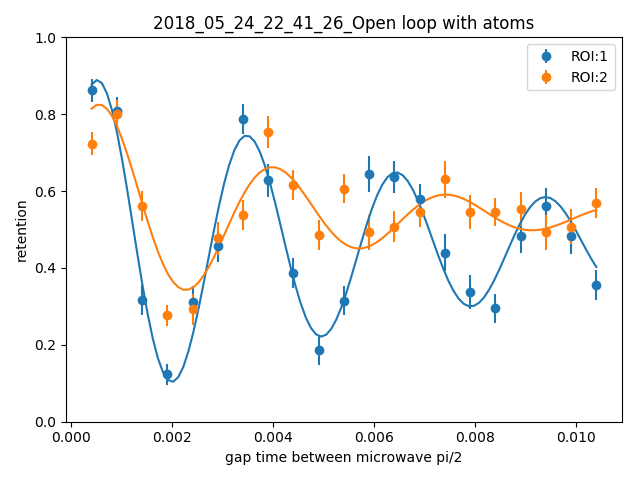

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00729033038482  with 1 std of   0.00140215092023
amplitude 1  is  0.46486139352  with 1 std of   0.0473753147101
frequency 1  is  337.824874936  with 1 std of   4.54149123765
phase 1  is  0.421222182992  with 1 std of   0.122453740984
offset 1  is  0.456689782219  with 1 std of   0.012746095624
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00416325705048  with 1 std of   0.00124757201094
amplitude 2  is  0.334225573313  with 1 std of   0.0651269263214
frequency 2  is  291.316335835  with 1 std of   13.0794173925
phase 2  is  0.436006904747  with 1 std of   0.25992778656
offset 2  is  0.53498923021  with 1 std of   0.0148035108703
2018_05_24_23_17_53_Open loop with atoms
24


<IPython.core.display.Javascript object>


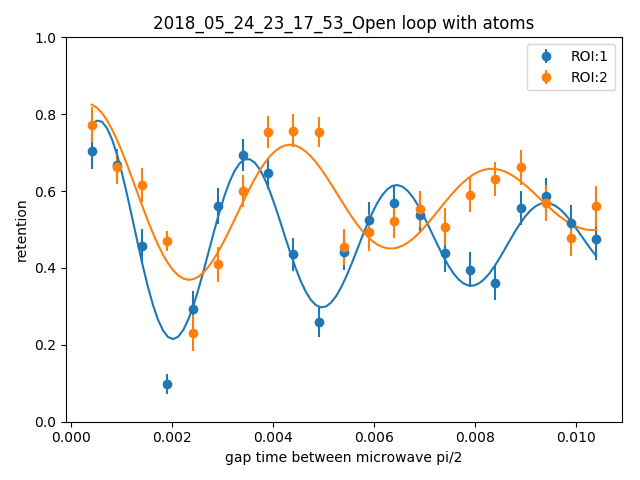

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.0076293757936  with 1 std of   0.00186852743214
amplitude 1  is  0.335244035246  with 1 std of   0.0425188538677
frequency 1  is  338.393426876  with 1 std of   5.4915662003
phase 1  is  0.37616569419  with 1 std of   0.150844601689
offset 1  is  0.471984208691  with 1 std of   0.0115360704649
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00760051235735  with 1 std of   0.00308205664607
amplitude 2  is  -0.27102910897  with 1 std of   0.0587012994929
frequency 2  is  250.079253607  with 1 std of   9.91111494198
phase 2  is  4.10719202256  with 1 std of   0.266935251223
offset 2  is  0.567859007314  with 1 std of   0.0161870413266
2018_05_25_03_19_13_Open loop, with atoms, side off
25


<IPython.core.display.Javascript object>


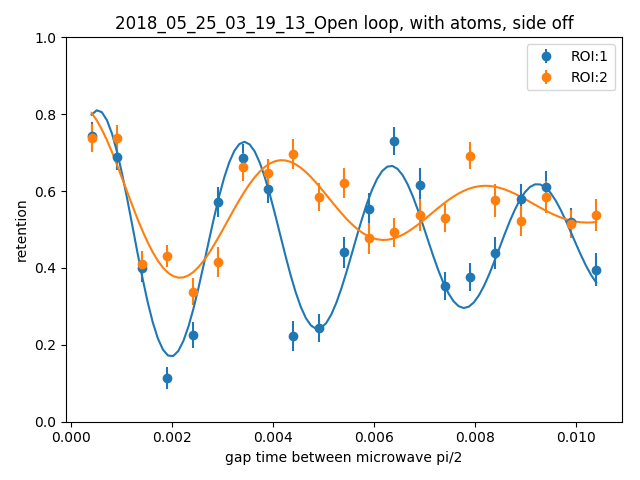

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.0105783792385  with 1 std of   0.0030414368441
amplitude 1  is  0.359973817188  with 1 std of   0.0442710471057
frequency 1  is  344.345015746  with 1 std of   4.72546898767
phase 1  is  0.399871482029  with 1 std of   0.143801280911
offset 1  is  0.468113064725  with 1 std of   0.0129842760871
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00520659878861  with 1 std of   0.0016548666363
amplitude 2  is  0.277633837583  with 1 std of   0.0575108572093
frequency 2  is  247.892589509  with 1 std of   10.8992997008
phase 2  is  1.23700448123  with 1 std of   0.240864114531
offset 2  is  0.556776118435  with 1 std of   0.0132620489256
2018_05_25_03_47_46_Open loop, with atoms, side off
26


<IPython.core.display.Javascript object>


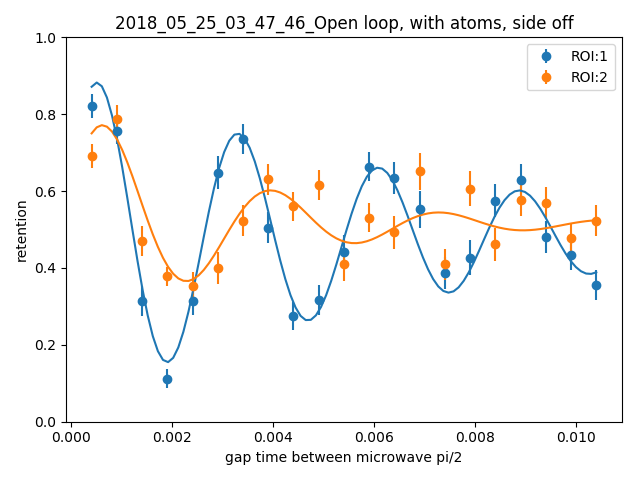

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00692716636741  with 1 std of   0.00107922671209
amplitude 1  is  0.431388026982  with 1 std of   0.0374080792209
frequency 1  is  358.519663006  with 1 std of   4.11995470507
phase 1  is  0.371994175895  with 1 std of   0.105848790161
offset 1  is  0.482128186276  with 1 std of   0.00999584625656
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00307940537348  with 1 std of   0.00126554357194
amplitude 2  is  0.317373218522  with 1 std of   0.0919424581466
frequency 2  is  299.941573881  with 1 std of   23.9555130953
phase 2  is  0.250406589844  with 1 std of   0.378856052269
offset 2  is  0.515002797494  with 1 std of   0.0171030366928
2018_05_25_04_08_37_Open loop, with atoms, side off
27


<IPython.core.display.Javascript object>


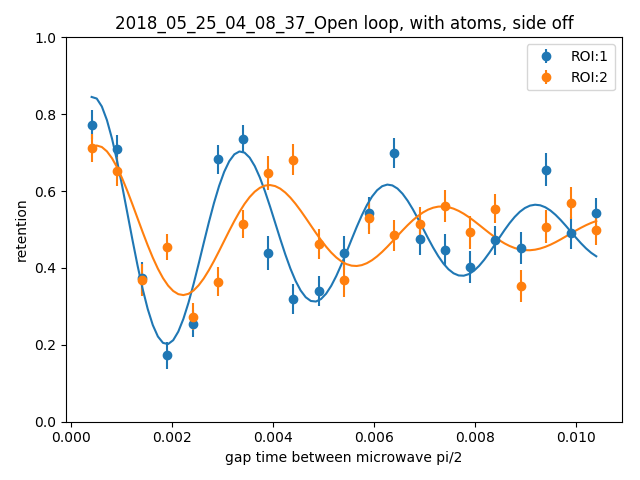

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00586288284249  with 1 std of   0.00166635008201
amplitude 1  is  0.390395367606  with 1 std of   0.0654097576044
frequency 1  is  341.959122858  with 1 std of   8.68806703683
phase 1  is  0.576825218934  with 1 std of   0.209399033947
offset 1  is  0.483530562072  with 1 std of   0.0166675890653
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00557498463363  with 1 std of   0.00255433507376
amplitude 2  is  0.246360072852  with 1 std of   0.0671425505883
frequency 2  is  292.435105338  with 1 std of   14.9348793591
phase 2  is  0.554487435245  with 1 std of   0.35361124176
offset 2  is  0.494391379531  with 1 std of   0.0172293423546
2018_05_25_04_30_15_Open loop, with atoms, side off
28


<IPython.core.display.Javascript object>


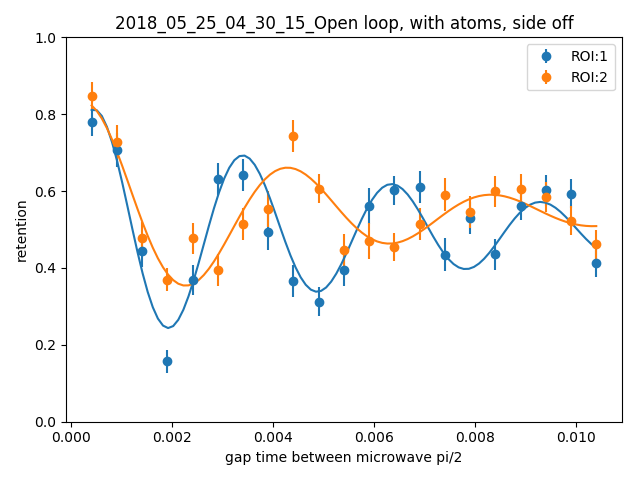

[0.016, 0.35, 350, 1.3, 0.5]
tau 1  is  0.00624218398348  with 1 std of   0.0016825312469
amplitude 1  is  0.342430777191  with 1 std of   0.0527907001376
frequency 1  is  339.290904088  with 1 std of   7.62111273176
phase 1  is  0.544102573574  with 1 std of   0.190549721352
offset 1  is  0.494673590108  with 1 std of   0.0136866482746
[0.016, 0.35, 350, 1.3, 0.5]
tau 2  is  0.00457869497959  with 1 std of   0.00125812725766
amplitude 2  is  0.309212503177  with 1 std of   0.0557740733976
frequency 2  is  247.937276431  with 1 std of   11.2284221084
phase 2  is  1.04743788362  with 1 std of   0.234705424528
offset 2  is  0.540792669425  with 1 std of   0.0129432566275


In [112]:
save_figures=False
data11 = []
for n in range(0,len(assorted['exp_ids'])):    
    print assorted['exp_ids'][n]
    assorted_roi3freqs=[]
    assorted_roi2freqs=[]
    assorted_roi3perr=[]
    assorted_roi2perr=[]
    i = n
    print i
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()


    colors=[ '#ff7f0e','#1f77b4','#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[0.016, 0.35, 350 ,1.3, 0.5]
    fit_guesses2=[0.016, 0.3, 200 ,1.3, 0.45]
    #roi_dependency=[0,0,0,0,0]
    fitted_parameters=[]
    freqarray = []
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []

        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        offsetguess = np.mean(reten)
        Ampguess = np.max(reten)-offsetguess
        #fit_guesses = [0.017,Ampguess , 350 ,np.pi/2, offsetguess]   
        print fit_guesses
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        #try:
       # decaying_sin(t,tau,amp,freq,phase,offset)
        try:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offset',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

        except:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offsett',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

           #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
       # except RuntimeError:
       #     error=1
    #     if error is not 1:
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])

        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=decaying_sin(xarray, fit[0], fit[1], fit[2], fit[3],fit[4])
        plt.plot(xarray,yfit,color=colors[roi])
           # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
            #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
            #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

    #         if roi==3:
    #             assorted_roi3freqs.append(fit[2])
    #             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
    #         elif roi==2:
    #             assorted_roi2freqs.append(fit[2])
    #             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    plt.tight_layout()
    plt.show()
    if save_figures:
        plt.savefig('{}.pdf'.format(exp_id))
    
    
    
    starting_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][0])).strftime('%Y-%m-%d %H:%M:%S')
    end_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][len(assorted['timestamps'][i])-1])).strftime('%Y-%m-%d %H:%M:%S')
    middle_time = dt.datetime.fromtimestamp(int((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 )).strftime('%H:%M')
    time_length = (assorted['timestamps'][i][len(assorted['timestamps'][i])-1])-assorted['timestamps'][i][0]
    time_from_data_start = ((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 ) - assorted['timestamps'][0][0] 
    data11.append([ starting_time,end_time,freqarray[0],freqarray[1],freqarray[2],freqarray[3],middle_time,time_length,time_from_data_start])



<IPython.core.display.Javascript object>


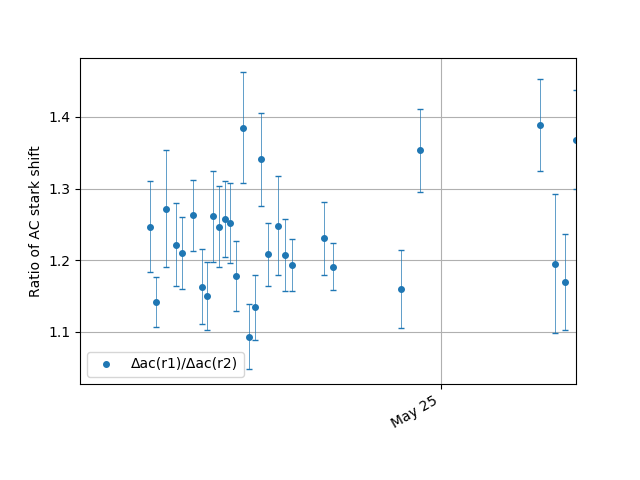

<IPython.core.display.Javascript object>


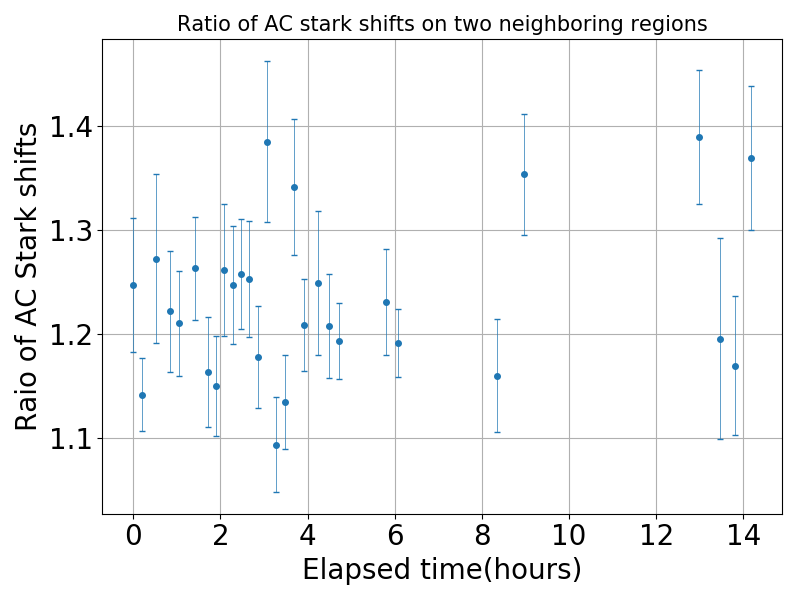

In [113]:
savefig=False
ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
startingtime_in_UNIX=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    startingtime_in_UNIX.append(assorted['timestamps'][i][0])
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])

#samplerate='2S'
#df=pd.DataFrame({  "Δac(r1)/Δac(r2)": ratio_data,'timestamps': avetimestamp,'error': ratio_error,'off_data': off_data},index=startingtime)
df=pd.DataFrame({  "Δac(r1)/Δac(r2)": ratio_data,'timestamps': avetimestamp,'error': ratio_error},index=startingtime)

ax=df.plot(y=[ "Δac(r1)/Δac(r2)"],yerr='error',capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',color=['#1f77b4', '#d62728'])
days=md.DayLocator()
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,5,24,12))
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('Ratio of AC stark shift')
ax.grid()
#plt.savefig('Alignment_20180415.png')

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
#ax.set_ylim(-0.3,0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='AC Stark shift ratios'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


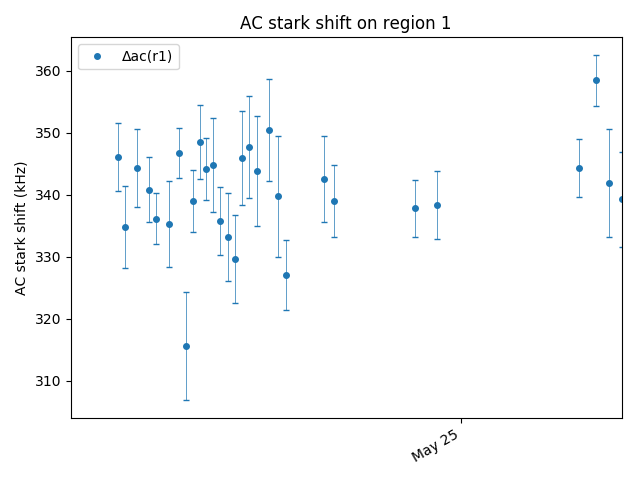

<IPython.core.display.Javascript object>


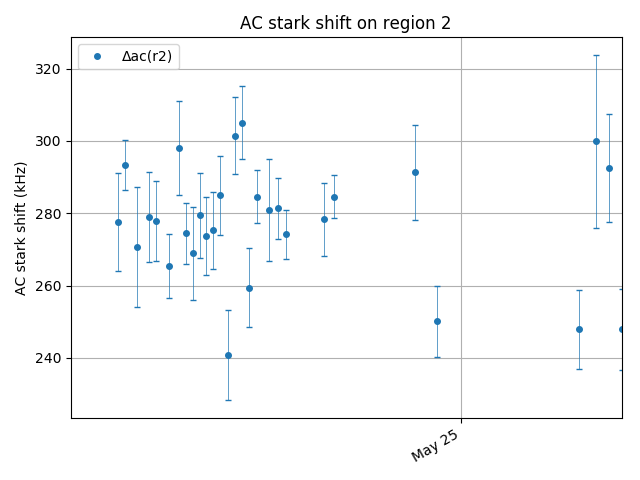

In [114]:

ROI1_ac=[]
ROI1_err=[]
ROI2_ac=[]
ROI2_err=[]
avetimestamp=[]
timelength=[]
startingtime=[]
ROI_err=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ROI1_ac.append(data11[i][2])
    ROI_err.append([data11[i][3],data11[i][5]])
   # ROI_err.append(data11[i][3])
   # ROI_err.append(data11[i][5])
    ROI1_err.append(data11[i][3])
    ROI2_ac.append(data11[i][4])
    ROI2_err.append(data11[i][5])
    #ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
 
# Using Pandas

df2=pd.DataFrame({  "Δac(r1)": ROI1_ac,'Δac(r2)':ROI2_ac,'timestamps': avetimestamp,'ROI_err': ROI_err},index=startingtime)

ax=df2.plot(y=[ "Δac(r1)"],yerr=ROI1_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax.set_xlim(dt.datetime(2018,5,24,13))
ax.xaxis.set_major_locator(days)
#ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shift on region 1')
plt.tight_layout()
if savefig:
    plt.savefig('r1_ac_starkshift.pdf')

ax2=df2.plot(y=[ "Δac(r2)"],yerr=ROI2_err,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
hours=md.HourLocator()
ax2.set_xlim(dt.datetime(2018,5,24,13))
ax2.xaxis.set_major_locator(days)
ax2.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax2.set_ylabel('AC stark shift')
ax2.grid()
ax2.set_ylabel('AC stark shift (kHz)')
ax2.set_title('AC stark shift on region 2')
plt.tight_layout()
if savefig:
    plt.savefig('r2_ac_starkshift.pdf')


In [115]:
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shift on region 1')
plt.tight_layout()
plt.savefig('r1_ac_starkshift')
# peakshift_r1 = 825.0
# peakshift_r2 = 825.0
# wx_r1 = 8.2
# wx_r2= 8.2
peakshift=825
wx=8.1
spacing = 9.25
xx = np.arange(-10.0, 10.0, 0.1)
# fig, ax = plt.subplots()
# plt.plot(xx,gaussian(xx,peakshift,-spacing/2,wx,0))
# plt.plot(xx,gaussian(xx,peakshift,spacing/2,wx,0))
# plt.show()

# fig, ax = plt.subplots()
# xxx = np.arange(-.3, 0.3, 0.005)
# plt.plot(xxx,(gaussian(xxx,peakshift,spacing/2,wx,0)/gaussian(xxx,peakshift,-spacing/2,wx,0)))
# plt.show()


In [116]:
def gaussian2(x,amp,x0,sigma,offset):
    res=(amp*sp.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res
#print gaussian(4,peakshift,spacing/2,wx,0)
#x=Symbol('x')
#print gaussian(y,peakshift,spacing/2,wx,0)
#print solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-1.1,x)


ratio_data=[]
ratio_error=[]
avetimestamp=[]
timelength=[]
startingtime=[]
avetimestamp=[]

for i in range(0,len(assorted['exp_ids'])):
#for i in [1]:
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ratio_error.append(error_total)
    avetimestamp.append(data11[i][6])
#print error_total
ratio_to_dist=[]  
x=Symbol('x')
dist_max_error=[]
dist_min_error=[]
error_all=[]
for z in range(0,len(ratio_error)):
    print "doing {}-th fit.. out of {}".format(z,len(ratio_error))
    center_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z],x)
    max_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]-ratio_error[z],x)
    min_val =  solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]+ratio_error[z],x)
    ratio_to_dist.append(np.float(center_val[0]))
    maxerr = max_val[0] - center_val[0]
    minerr = center_val[0]- min_val[0]
    dist_max_error.append(np.float(maxerr))
    dist_min_error.append(np.float(minerr))
    error_all.append([np.float(maxerr),np.float(minerr)])

doing 0-th fit.. out of 29
doing 1-th fit.. out of 29
doing 2-th fit.. out of 29
doing 3-th fit.. out of 29
doing 4-th fit.. out of 29
doing 5-th fit.. out of 29
doing 6-th fit.. out of 29
doing 7-th fit.. out of 29
doing 8-th fit.. out of 29
doing 9-th fit.. out of 29
doing 10-th fit.. out of 29
doing 11-th fit.. out of 29
doing 12-th fit.. out of 29
doing 13-th fit.. out of 29
doing 14-th fit.. out of 29
doing 15-th fit.. out of 29
doing 16-th fit.. out of 29
doing 17-th fit.. out of 29
doing 18-th fit.. out of 29
doing 19-th fit.. out of 29
doing 20-th fit.. out of 29
doing 21-th fit.. out of 29
doing 22-th fit.. out of 29
doing 23-th fit.. out of 29
doing 24-th fit.. out of 29
doing 25-th fit.. out of 29
doing 26-th fit.. out of 29
doing 27-th fit.. out of 29
doing 28-th fit.. out of 29


<IPython.core.display.Javascript object>


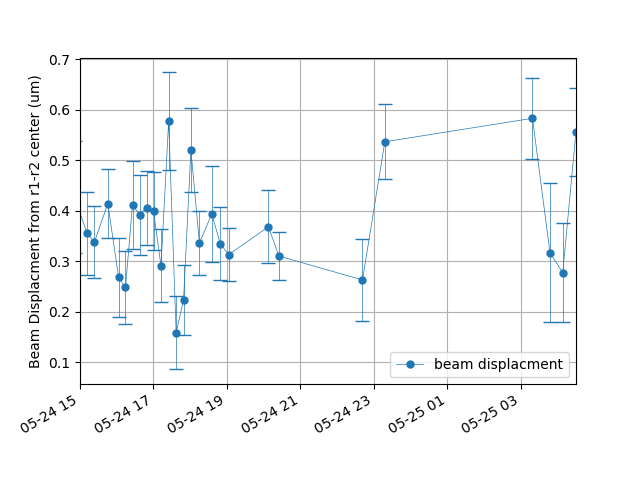

In [117]:
df4=pd.DataFrame({ "beam displacment": ratio_to_dist,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df4.plot(y=["beam displacment"],yerr=[dist_max_error,dist_min_error],capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from r1-r2 center (um)')
ax.set_xlim(dt.datetime(2018,5,24,15))
ax.grid()

<IPython.core.display.Javascript object>


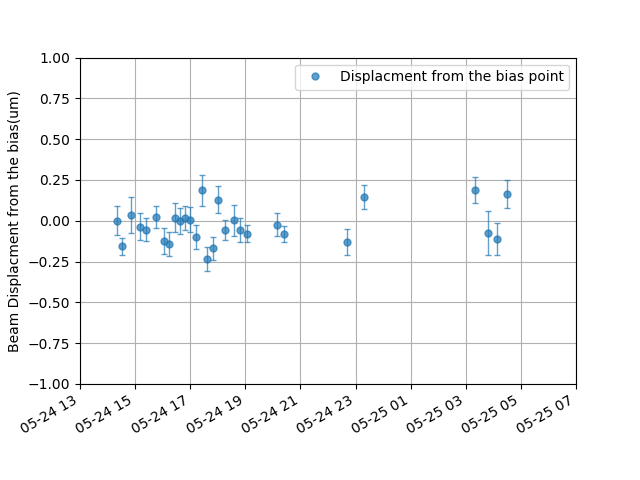

In [120]:
start_offset=np.mean(ratio_to_dist[0]) # Off
displacement_frombias=ratio_to_dist-start_offset
df5=pd.DataFrame({"Displacment from the bias point":displacement_frombias ,'Max_error': dist_max_error,'Min_error': dist_min_error},index=startingtime)
ax=df5.plot(y=["Displacment from the bias point"],yerr=[dist_max_error,dist_min_error],capsize=2,lw=1,marker='o',alpha=0.7,linestyle='None',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from the bias(um)')
ax.set_xlim(dt.datetime(2018,5,24,13),dt.datetime(2018,5,25,7))
ax.set_ylim(-1,1)

#days=md.DayLocator()
#ax.xaxis.set_major_locator(days)
#ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))

ax.grid()

<IPython.core.display.Javascript object>


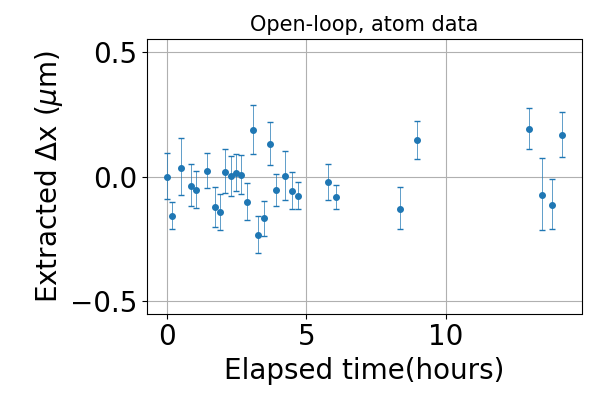

In [127]:
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Extracted $\Delta$x ($\mu$m)',fontsize=20)
ax.set_title('Open-loop, atom data',fontsize=15)
ax.set_ylim(-0.55,0.55)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='20180522_Extracted_OpenLoop'
plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')

# TIME SERIES ANALYSES

In [95]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

actuator_variables=['Red_X','Red_Y']

# exp_ids : This is list for Ramsey experiments.
# There are more experients with AAS on. Add them in this list
AAS_ids=[
        ]

entire_closed_ids=exp_ids+AAS_ids


data={}
for j in range(0,len(entire_closed_ids)):
    exp_id=entire_closed_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)

        for var in actuator_variables:
            if i==0 and j==0:
                data[var]=[]
            try:
                data[var].append(q.experiments[e]['iterations'][i]['variables'][var])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, var)
                

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_14_20_18_Open loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_14_31_57_Open loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_14_50_50_Open loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_15_11_23_Open loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_15_23_23_Open loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_15_45_20_Open loop with atoms/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_05_24/2018_05_24_16_02_54_Open loop with atoms/

<IPython.core.display.Javascript object>


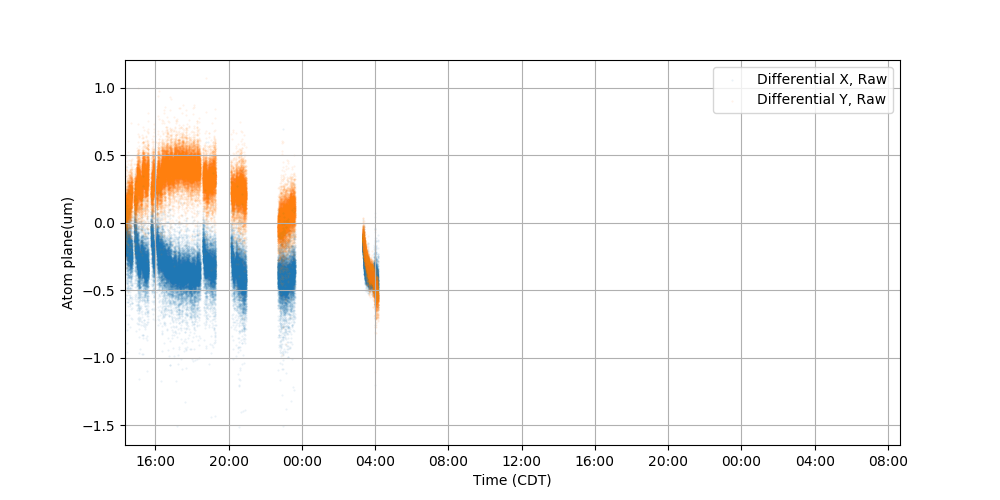

In [96]:
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=0.2,alpha=0.1,label='Differential X, Raw')
ax.set_xlim(dates[0],)
#ax.set_ylim(-1,1)

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=0.2,alpha=0.1,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:   
    plt.savefig('Alignment_over_night.png')

In [45]:
flattendedtimestamps[0]

1527019230.6429999

<IPython.core.display.Javascript object>


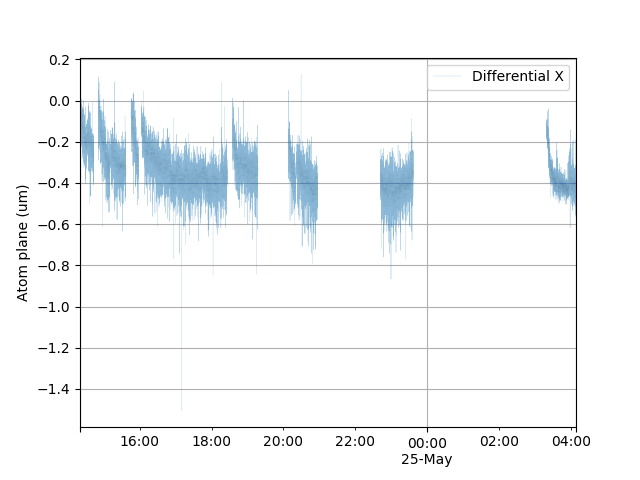

<IPython.core.display.Javascript object>


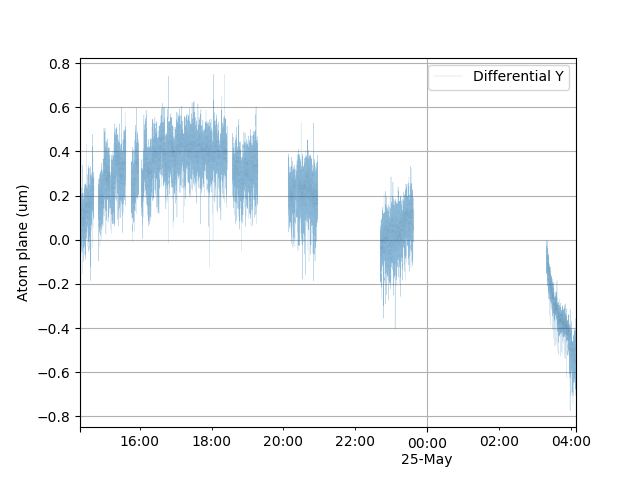

<IPython.core.display.Javascript object>


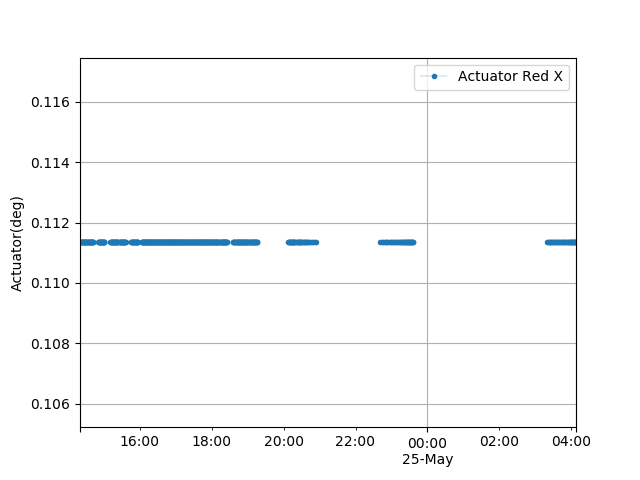

<IPython.core.display.Javascript object>


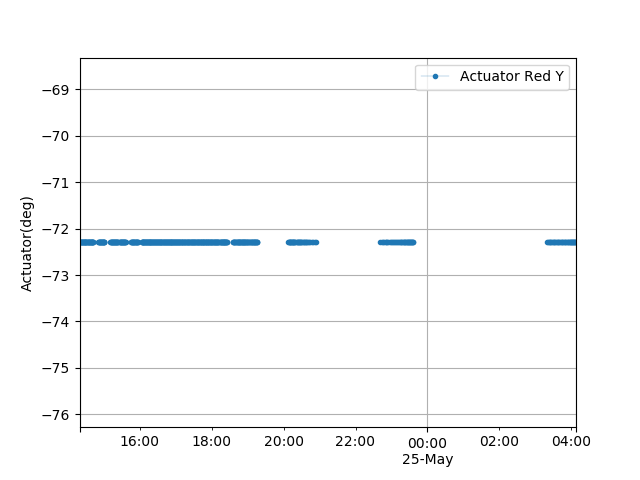

In [97]:
# Using Pandas
import pandas as pd
savefig=False
data_cutoff=0
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))

dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]
dates_iterations=[dt.datetime.fromtimestamp(ts) for ts in data['timestamp_iteration']]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='1S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0,
                 'Red Y': flatteneddata1,
                 'FORT X': flatteneddata2,
                 'FORT Y': flatteneddata3,
                },index=dates)

df_actuators=pd.DataFrame({
                 'Actuator Red X':np.array(data['Red_X']),
                 'Actuator Red Y':np.array(data['Red_Y'])
                },index=dates_iterations)


## 
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential X'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

ax=data_to_plot2.plot(y=['Differential Y'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

data_to_plot3=df_actuators.resample(samplerate).mean()

ax=data_to_plot3.plot(y=['Actuator Red X'],alpha=1,lw=0.2,marker='.')
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()

ax=data_to_plot3.plot(y=['Actuator Red Y'],alpha=1,lw=0.2,marker='.')
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()

<IPython.core.display.Javascript object>


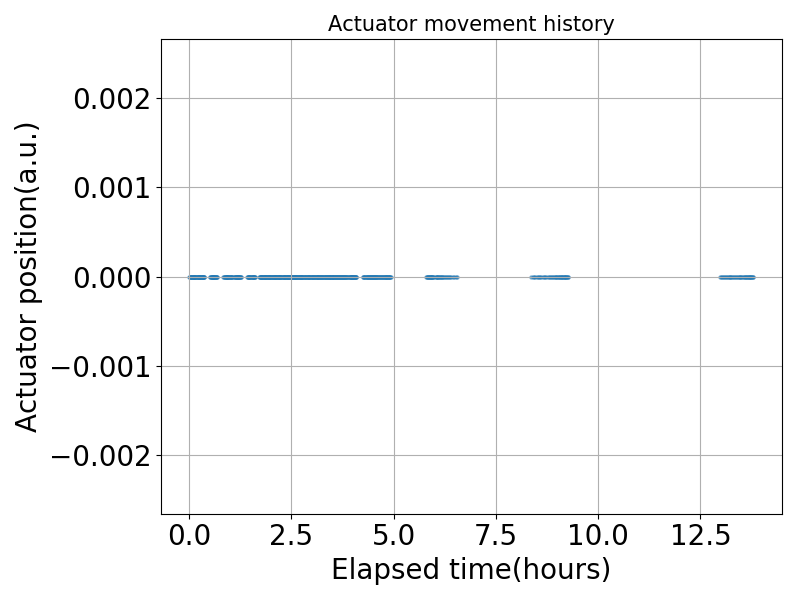

<IPython.core.display.Javascript object>


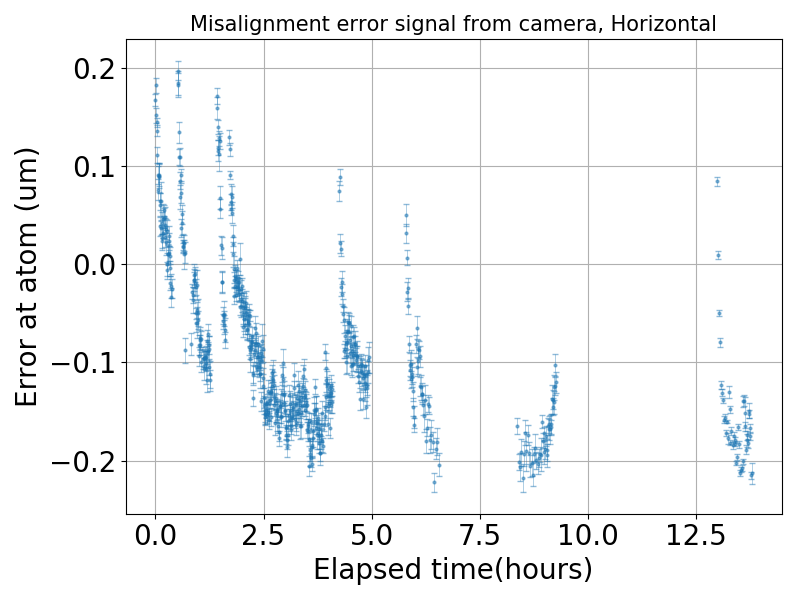

In [98]:
## Actuator Plot
savefig=False
actuator_x=np.array(data['Red_X'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_x-actuator_x[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, X
camera_error_x=[]
camera_error_sigma_x=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_x.append(data[keylist[4]][i]['error_x']/calibration_factor)
        camera_error_sigma_x.append(data[keylist[4]][i]['sigma_x']/math.sqrt(samples))
    except:
        print i
        camera_error_x.append(np.nan)
        camera_error_sigma_x.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Horizontal',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


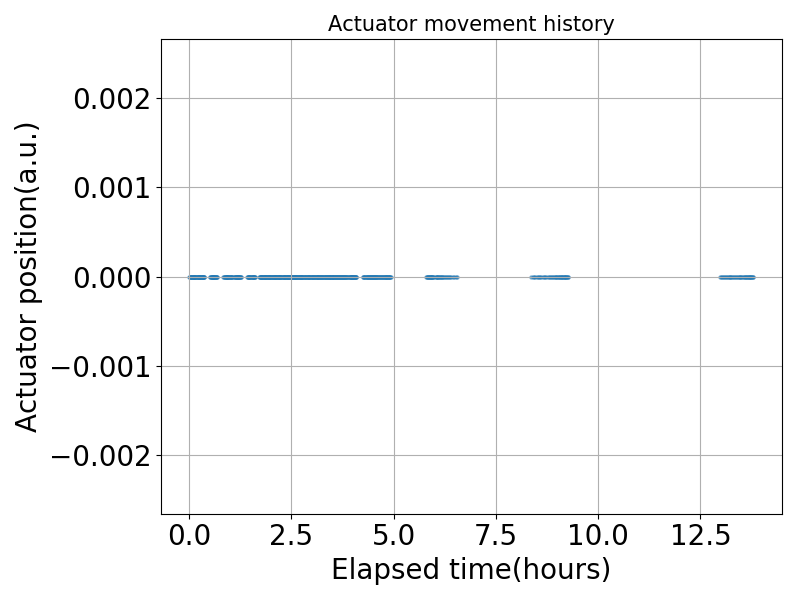

<IPython.core.display.Javascript object>


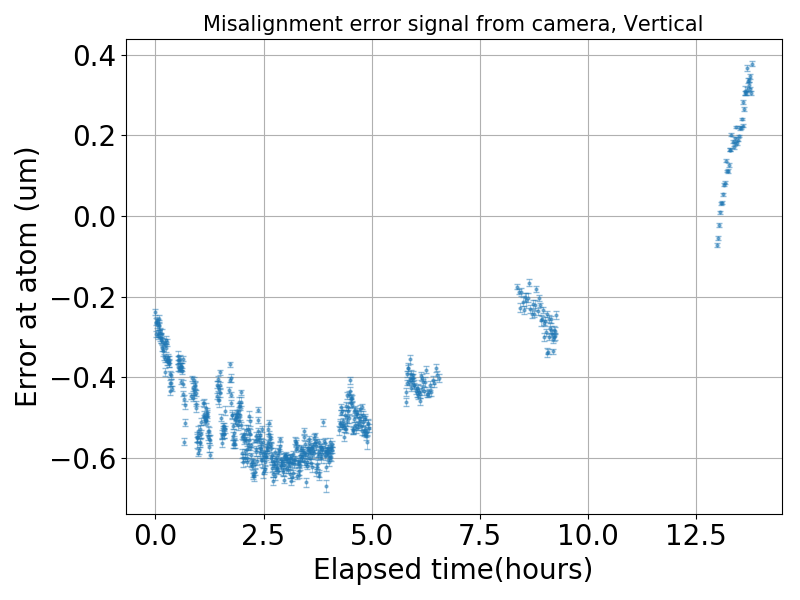

In [99]:
## Actuator Plot
savefig=False
actuator_y=np.array(data['Red_Y'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_y-actuator_y[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, Y
camera_error_y=[]
camera_error_sigma_y=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_y.append(data[keylist[4]][i]['error_y']/calibration_factor)
        camera_error_sigma_y.append(data[keylist[4]][i]['sigma_y']/math.sqrt(samples))
    except:
        print i
        camera_error_y.append(np.nan)
        camera_error_sigma_y.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_y,yerr=camera_error_sigma_y,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Vertical',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

# Figuring out the dead region

<IPython.core.display.Javascript object>


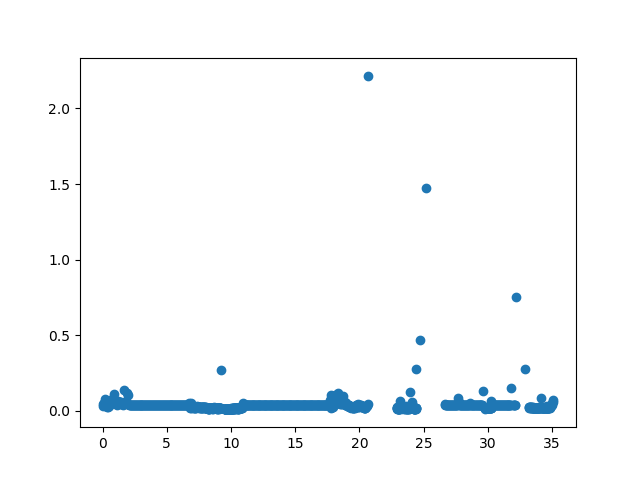

T=20.6829047222, duration of :2.21701666666


In [18]:
fig, ax= plt.subplots()
sorted_times=np.sort(elapsed_time_in_hours)
dead_times=sorted_times[1:]-sorted_times[0:-1]
ax.scatter(sorted_times[0:-1],dead_times)
threshold=2
dead_T=[]
dead_duration=[]
for i in range(0,len(dead_times)):
    if dead_times[i]>threshold:
        print 'T={}, duration of :{}'.format(sorted_times[0:-1][i],dead_times[i])
        dead_T.append(sorted_times[0:-1][i])
        dead_duration.append(dead_times[i])

<IPython.core.display.Javascript object>


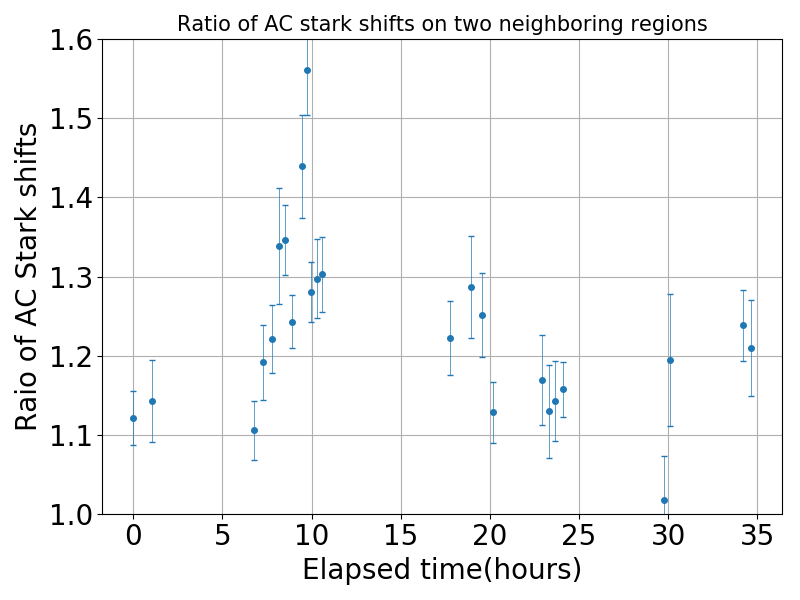

In [19]:
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='r')
ax.set_ylim(1.3-0.3,1.3+0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()

# Insert room temperature history

<IPython.core.display.Javascript object>


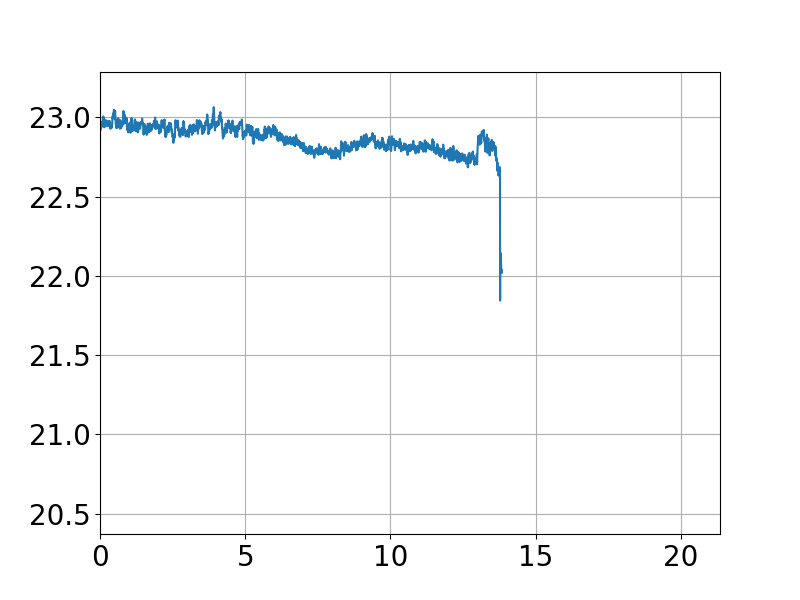

22.6327109524


In [100]:
from numpy import genfromtxt
my_data=genfromtxt('Rb_labtemperature.csv',delimiter=',')
temperatures_in_C=np.array(my_data[:,1])
timestamps=np.array(my_data[:,0])/2**32
offset=temperatures_in_C[0]#np.mean(temperatures_in_C)
experiment_start_time=flattendedtimestamps[0]
# Cutting weird data off (due to bad eletric connection.. etc)
temp_threshold_upper=25
temp_threshold_lower=20.5

indices1 = temperatures_in_C > temp_threshold_upper
indices2 = temperatures_in_C < temp_threshold_lower
final_indices=np.logical_or(indices1,indices2)
temperatures_in_C[final_indices]=np.NaN
fig, ax=plt.subplots()
fig.set_size_inches(8,6)
ax.plot((timestamps-experiment_start_time)/3600,temperatures_in_C)
ax.grid()
ax.set_xlim(0,)
#ax.set_ylim(18,23)
ax.tick_params(labelsize=20)

# for i in range(0,len(dead_T)):
#      ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],-0.4,0.4,alpha=0.1,color='r')

print temperatures_in_C[0]

In [48]:
my_data

array([[  6.55712007e+18,   2.26327110e+01,   3.34742380e+03],
       [  6.55712008e+18,   2.26325596e+01,   3.34744660e+03],
       [  6.55712016e+18,   2.26359802e+01,   3.34693150e+03],
       ..., 
       [  6.55735520e+18,   2.24339886e+01,   3.37750250e+03],
       [  6.55735521e+18,   2.24349951e+01,   3.37734940e+03],
       [  6.55735522e+18,   2.24367175e+01,   3.37708740e+03]])

<IPython.core.display.Javascript object>


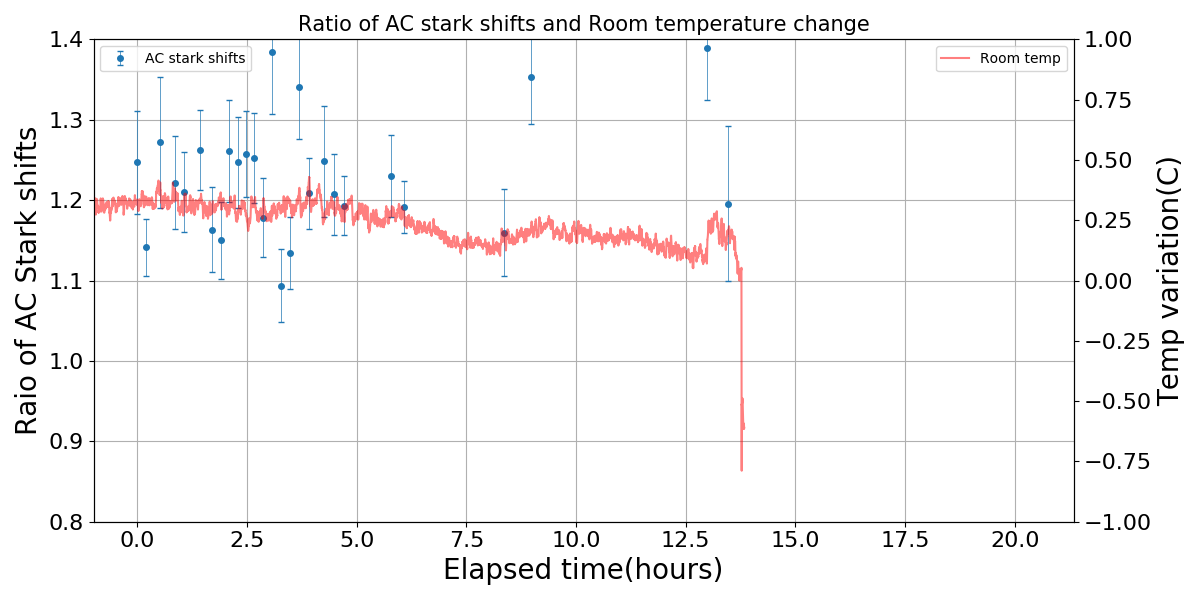

In [101]:
# Together!!
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='AC stark shifts')
ax2=ax.twinx()
ax2.plot((timestamps-experiment_start_time)/3600,temperatures_in_C-offset,color='r',alpha=0.5,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax2.set_ylabel('Temp variation(C)',fontsize=20)
ax.set_title('Ratio of AC stark shifts and Room temperature change',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='gray')

ax.set_xlim(-1,)
ax.set_ylim(1.1-0.3,1.1+0.3)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylim(-1,1)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# filename='20180422_AC_starkshifts and temperature'
# plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')


<IPython.core.display.Javascript object>


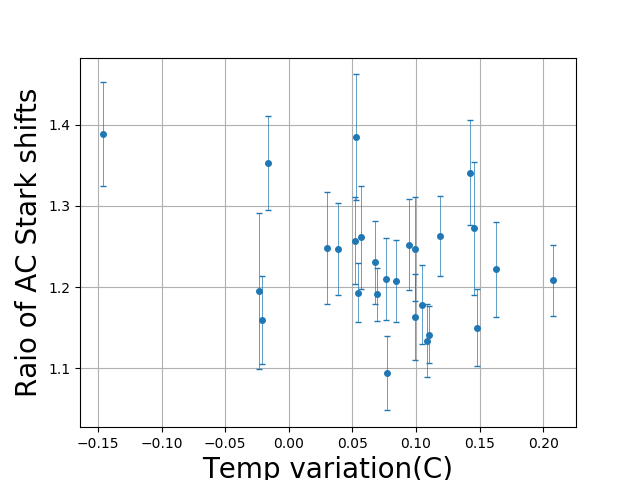

In [102]:
offset=22.85
interpolated_temperature=np.interp(timediff,(timestamps-experiment_start_time)/3600,temperatures_in_C-offset)
fig, ax=plt.subplots()
#ax.scatter(interpolated_temperature,ratio_data)
ax.errorbar(interpolated_temperature,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
#ax.set_aspect('equal')
ax.set_xlabel('Temp variation(C)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.grid()

<IPython.core.display.Javascript object>


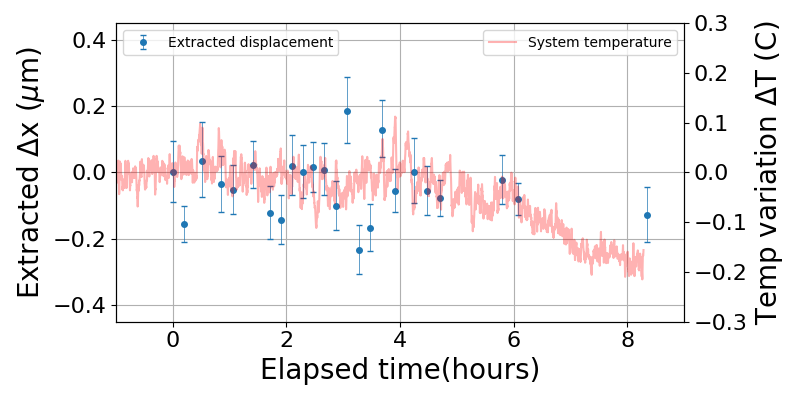

In [72]:
offset=22.95
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
ax2=ax.twinx()
ax2.plot((timestamps-experiment_start_time)/3600,temperatures_in_C-offset,color='r',alpha=0.3,label='System temperature')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Extracted $\Delta$x ($\mu$m)',fontsize=20)
ax2.set_ylabel(r'Temp variation $\Delta$T (C)',fontsize=20)
#ax.set_title('',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],-0.45,0.45,alpha=0.1,color='gray')
scaler=1
ax.set_ylim(scaler*-0.45,scaler*0.45)
ax2.set_ylim(scaler*-0.3,scaler*0.3)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax.set_xlim(-1,9)
filename='20180522_Extracted_horizontal_misalignment_and_Temperature_Openloop'
savefig=True
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


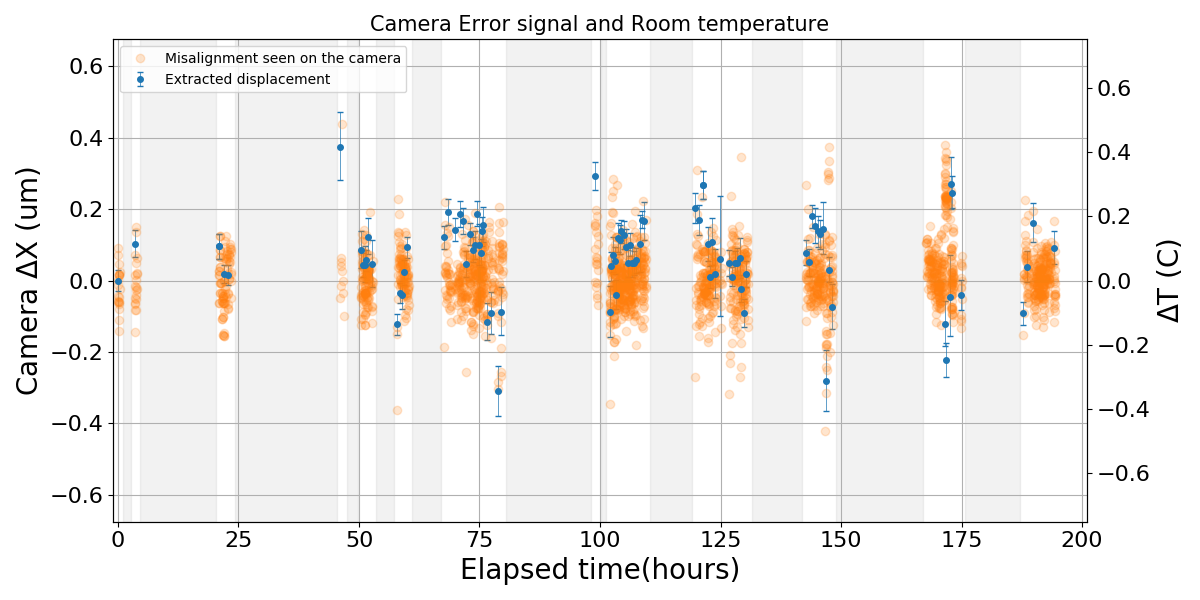

In [209]:
## Temperature and camera error signal plot
## Use pandas and resampling to plot them at similar time scale?
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
ax.plot(elapsed_time_in_hours,camera_error_x,label='Misalignment seen on the camera',marker='o',linestyle='none',alpha=0.2)
ax2=ax.twinx()
#ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.8,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Camera $\Delta$X (um)',fontsize=20)
ax2.set_ylabel(r'$\Delta$T (C)',fontsize=20)
ax.set_title('Camera Error signal and Room temperature',fontsize=15)
scaler=1.5
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],scaler*-0.45,scaler*0.45,alpha=0.1,color='gray')

ax.set_ylim(scaler*-0.45,scaler*0.45)
ax2.set_ylim(scaler*-0.5,scaler*0.5)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax.set_xlim(-1,201)
filename='20180428_Camera_and_Atom_comparison'
savefig=True
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

In [ ]:
## Temperature and camera error signal plot
## Use pandas and resampling to plot them at similar time scale?
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
#ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.1,lw=0.5,marker='o',markersize=4,linestyle='None',label='Extracted displacement')
#ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,markersize=4,linestyle='None',label='Extracted displacement')
ax.plot(elapsed_time_in_hours,camera_error_x,label='Extracted displacement',marker='o',linestyle='none',alpha=0.2)
#ax.hexbin(elapsed_time_in_hours,camera_error_x,gridsize=(300,10),label='Extracted displacement')
#ax.hexbin(elapsed_time_in_hours,camera_error_x,gridsize=(300,10),label='Extracted displacement')
ax2=ax.twinx()
ax2.plot(timestamps,temperatures_in_C-offset,color='r',alpha=0.8,label='Room temp')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel(r'Camera $\Delta$X (um)',fontsize=20)
ax2.set_ylabel(r'$\Delta$T (C)',fontsize=20)
ax.set_title('Camera Error signal and Room temperature',fontsize=15)
scaler=1.5
for i in range(0,len(dead_T)):
    ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],scaler*-0.45,scaler*0.45,alpha=0.1,color='gray')

ax.set_ylim(scaler*-0.45,scaler*0.45)
ax2.set_ylim(scaler*-0.5,scaler*0.5)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.grid()
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax.set_xlim(-1,201)
filename='20180428_camera_horizontal_misalignment_and_Temperature'
savefig=False
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


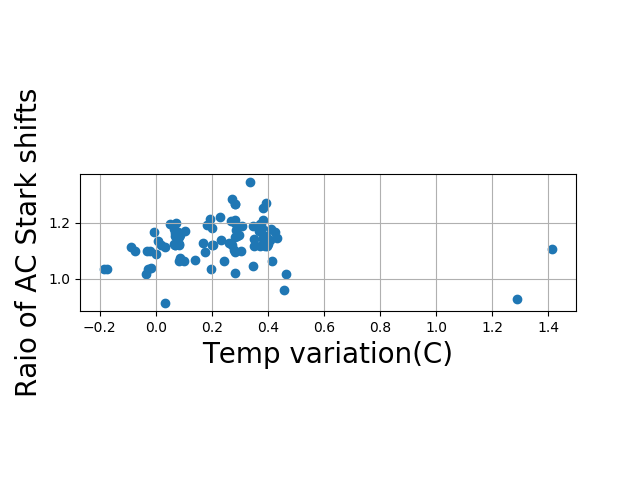

In [51]:
interpolated_temperature=np.interp(timediff,timestamps,temperatures_in_C-offset)
fig, ax=plt.subplots()
ax.scatter(interpolated_temperature,ratio_data)
ax.set_aspect('equal')
ax.set_xlabel('Temp variation(C)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.grid()

<IPython.core.display.Javascript object>


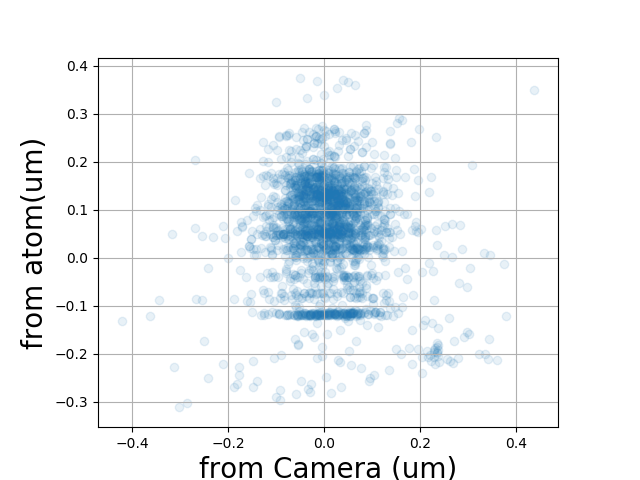

In [172]:
# Camera Error signal vs Atom signal
# elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x
time_offset=0
#interpolated_error_x=np.interp(timediff+time_offset,elapsed_time_in_hours,camera_error_x)
interpolated_atom_x=np.interp(elapsed_time_in_hours+time_offset,timediff,displacement_frombias)
fig, ax=plt.subplots()
#ax.hexbin(camera_error_x,interpolated_atom_x,gridsize=40)
#ax.scatter(camera_error_x,interpolated_atom_x,alpha=0.1)
ax.set_aspect('equal')
ax.set_xlabel('from Camera (um)',fontsize=20)
ax.set_ylabel('from atom(um)',fontsize=20)
ax.grid()
ax.set_aspect('equal')

In [154]:
np.size(elapsed_time_in_hours)

2195

In [126]:
timediff

array([   0.        ,    3.48471694,   20.94659722,   20.94659722,
         22.02374889,   22.83502472,   46.14175194,   50.43195417,
         50.84260028,   51.18150556,   51.51876861,   51.89722056,
         52.62958306,   57.91884361,   58.47059389,   58.96669083,
         59.43727583,   59.87217111,   67.66185556,   68.4693075 ,
         69.94930583,   70.91257583,   71.56578667,   72.24758389,
         72.94265833,   73.585415  ,   73.98553194,   74.47450361,
         74.86974083,   75.21645028,   75.52191667,   75.8017675 ,
         76.52271417,   77.30667389,   78.7948975 ,   79.47338528,
         98.91573222,  102.01844167,  102.33729306,  102.68075111,
        103.04679111,  103.39736528,  103.73350472,  104.14270861,
        104.44181667,  104.89870722,  105.32815   ,  105.78663028,
        106.17394333,  106.56550694,  106.95965389,  107.38826667,
        108.2555825 ,  108.67492139,  109.06880278,  119.80086333,
        120.55649056,  121.37411861,  121.37411861,  122.35684

# Allan deviation

In [46]:
from IPython.display import display, clear_output
# Allan 
tau_list=range(1,100)+range(101,1001,10)+range(1002,10002,100)+range(10003,100003,100)#+range(80004,100004,50)+range(100005,1000005,500)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    clear_output()
    display('Tau: '+str(tau))
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass

'Tau: 99903'

<IPython.core.display.Javascript object>


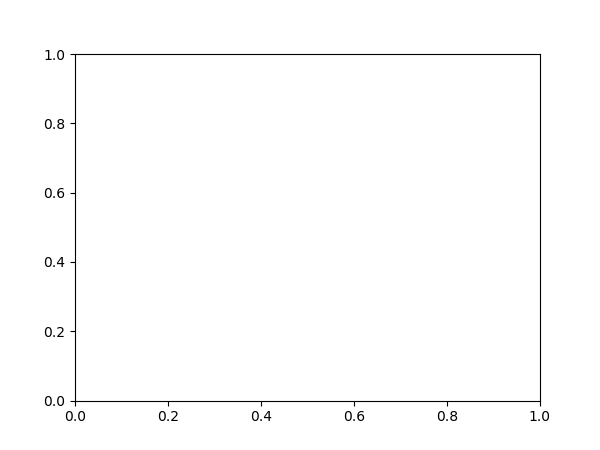

KeyError: 'Differential X'

In [47]:
savefig=False
fig, ax = plt.subplots()
fig.set_size_inches(6,4.5)
#xdata=tau_lists
#for key in var_list:
#i=['Diff X(closed-loop)','Diff Y(open-loop)']
#for key in ['Differential X','Differential Y']:
ax.semilogx(tau_list, np.sqrt(0.5*np.array(var_list['Differential X'])),label=r'$\Delta$X(closed-loop)',alpha=0.5)
ax.semilogx(tau_list, np.sqrt(0.5*np.array(var_list['Differential Y'])),label=r'$\Delta$Y(closed-loop)',alpha=0.5)
#ax.semilogx(tau_list, np.sqrt(Yvar_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Xvariance_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Yvariance_list),label='Diff Y',alpha=0.5)
ax.legend()
plt.axvline(x=86400,color='red',alpha=0.5)
#ax.set_xlim(1,)
ax.set_title('Allan Deviation of beam position measurements')
ax.set_xlabel(r'Integration time $\tau$ (s)')
ax.set_ylabel(r'ADEV ($\mu$m)')
ax.text(10**0,0.3,'Feedback uses last 100 measurements(~ 30 sec)\n from each iteration.\nFeedback cycle time typically ~ 2 min, when activated')
ax.text(10**5,0.37,'1 day')
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.0,0.5)
ax.grid()
plt.tight_layout()
filename='20180522_AllanDeviation_closedloop'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')
